In [1]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle
from lemaitre import bandpasses

/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [4]:
%matplotlib inline

In [5]:
%load_ext line_profiler

# Nice plots

In [ ]:
bgs_df = load_bgs(
    path="/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/BGS_v2/z0.200/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph000.fits",
    filename='Abacus.csv',
    columns=[
        "RA",
        "DEC",
        "Z",
        "Z_COSMO",
        "STATUS",
    ]
)

In [ ]:
# bgs_df[bgs_df['z'] < 0.15].to_csv('./data/Abacus.csv')

In [ ]:
%matplotlib inline

In [ ]:
fig = corner_(
    bgs_df[::50], var_names=["ra", "dec", "z", "z_cosmo"]
)

In [ ]:
_ = plt.hist(bgs_df["z"], 100)

In [ ]:
%matplotlib inline

from astropy.cosmology import Planck18 as cosmo
dist = cosmo.comoving_distance(bgs_df[::20]['z'])
x = np.cos(np.pi/180*bgs_df[::20]['ra'])*np.cos(np.pi/180*bgs_df[::20]['dec'])*dist
y = np.sin(np.pi/180*bgs_df[::20]['ra'])*np.cos(np.pi/180*bgs_df[::20]['dec'])*dist
z = np.sin(np.pi/180*bgs_df[::20]['dec'])*dist

scatter_3d(x,y,z)

plt.title('2% of Abacus galaxies')
# plt.savefig('../figures/Abacus.png')

In [ ]:
survey = extract_ztf()
survey.date_range

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection="mollweide"))
scatter_mollweide(bgs_df[::20], ax=ax, color="k", alpha=0.05, label="Uchuu galaxies")
scatter_mollweide(data, ax=ax, color="r", alpha=0.8, label="Sampled SN")
plt.legend(loc="upper right")
plt.savefig("../figures/SN_ra_dec_sampling.png")

In [ ]:
ztf_sn = pandas.read_csv("data/data_ztf.csv", index_col=0)

In [ ]:
    import dustmaps.planck
    dustmaps.planck.fetch()

In [ ]:
snia=SNeIa_full_bgs()
_=snia.draw(size=500000, inplace=True, zmax=0.06)

In [ ]:
%matplotlib inline
snia.data['redshift'].plot.hist(bins=49, histtype='step', density=True, label='Homogeneous Universe')
_=plt.hist(bgs_df[bgs_df["z"] < 0.06]["z"], 100, histtype='step', density=True, label='Abacus Galaxies')
ztf_sn[ztf_sn['z'] < 0.06]['z'].plot.hist(bins=45, histtype='step', label='ZTF DR2.5', density=True)
plt.legend()
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Distortion in redshift space')
plt.savefig('../figures/Redshift_distortion.png')

In [ ]:
from skysurvey import DataSet

dset = DataSet(lc)
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(data))

good : 18
bad : 57, 61, 

In [ ]:
data[~data["good"]]

In [ ]:
dset_sanitize_and_filter(dset)

In [ ]:
plot_lc(dset, dset.targets.data[dset.targets.data["keep"]].index[i])
i += 1

# General LC generation

In [65]:
import os

In [6]:
ztf = extract_ztf()

2024-06-19 06:42:54,136 INFO Loading ZTF survey


In [68]:
from shapely import geometry

snls = skysurvey.GridSurvey.from_pointings(data=pandas.read_csv('data/snls_obslogs_cured.csv', encoding='utf-8'),
                            footprint=geometry.box(-0.5, -0.5, 0.5, 0.5),
                            fields_or_coords={'D1': {'ra': 36.450190, 'dec': -4.45065},
                                    'D2': {'ra': 150.11322, 'dec': +2.21571},
                                    'D3': {'ra': 214.90738, 'dec': +52.6660},
                                    'D4': {'ra': 333.89903, 'dec': -17.71961}},)


In [44]:
subaru = skysurvey.Survey.from_pointings(pandas.read_csv('data/hsc_logs_realistic_skynoise.csv', index_col=0),
                                         geometry.Point(0,0).buffer(0.7))

In [45]:
snia = skysurvey.SNeIa()

In [46]:
survey = subaru

In [47]:
snia.update_model(t0={"func":np.random.uniform, 'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}},
                  redshift={"kwargs": {'zmax':1.6,}, 'as':'z'})

In [48]:
source = sncosmo.SALT2Source(modeldir='./data/SALT_snf', m0file='nacl_m0_test.dat', m1file='nacl_m1_test.dat', clfile='nacl_color_law_test.dat')
model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])

In [49]:
snia.set_template(model)

In [50]:
_ = snia.draw(
    tstart=survey.date_range[0], tstop=survey.date_range[1], inplace=True, skyarea=survey.get_skyarea().buffer(0.01), zmax=1.6
)

In [51]:
snia.data

z     x1      c            t0          ra       dec     magabs  \
0      1.24175  1.305  0.020  58730.839844   37.530708 -3.990914 -19.482910   
1      1.13585  0.080 -0.052  58486.816406   36.246914 -5.463830 -19.395281   
2      0.38565  1.605  0.043  58619.445312  151.310654  1.696854 -19.365957   
3      1.03305  0.865  0.068  59405.253906  149.752396  1.772001 -19.210411   
4      1.13305 -1.905 -0.036  57993.683594   35.148159 -4.839939 -18.983957   
...        ...    ...    ...           ...         ...       ...        ...   
23868  0.94815 -2.150 -0.027  59190.449219  149.264984  1.428892 -19.095140   
23869  0.45115  0.225  0.072  59453.000000  149.378036  1.884788 -19.235992   
23870  1.02635 -1.670  0.039  58877.019531  150.528595  2.082341 -18.821701   
23871  1.04205 -1.415 -0.065  58919.000000   37.316082 -4.075730 -19.188284   
23872  1.55395 -1.475  0.557  57903.398438   35.341286 -4.061857 -17.418880   

          magobs            x0 template  
0      25.256470  1.261336e-06     None  
1      25.105423  1.449605e-06     None  
2      22.292173  1.934415e-05     None  
3      25.036339  1.544839e-06     None  
4      25.510139  9.985359e-07     None  
...          ...           ...      ...  
23868  24.922247  1.716013e-06     None  
23869  22.824484  1.184748e-05     None  
23870  25.407639  1.097398e-06     None  
23871  25.081680  1.481654e-06     None  
23872  27.920193  1.084780e-07     None  

[23873 rows x 10 columns]

In [52]:
filterlib = bandpasses.get_filterlib()

In [53]:
from lemaitre import bandpasses

In [16]:
snls.data.band = snls.data.band.apply(lambda x : 'megacam6::' + x[-1])

In [17]:
snls.data.replace({'megacam6::i':'megacam6::i2', 'megacam6::y':'megacam6::i2'}, inplace=True)

In [69]:
np.unique(snls.data.band)

array(['MEGACAMPSF::g', 'MEGACAMPSF::i', 'MEGACAMPSF::r', 'MEGACAMPSF::y',
       'MEGACAMPSF::z'], dtype=object)

In [56]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, incl_error=False)

/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/skysurvey/dataset.py:800: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()
/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [57]:
index = dset_sanitize_and_filter(dset)

2024-06-19 07:09:53,601 INFO Correcting rate to observations and filtering based on observations


  0%|          | 0/23489 [00:00<?, ?it/s]

2024-06-19 07:10:28,077 INFO Done


# Uchuu thingies

### Fit cosmo sur les points tirés

In [ ]:
snia_default = skysurvey.SNeIa()
_ = snia_default.draw(
    tstart=survey.date_range[0], tstop=survey.date_range[1], inplace=True, zmax=0.06
)
# _ = snia_default.draw(size=10000, inplace=True,  zmax=0.06)

In [ ]:
snia_default.data.plot.scatter(
    "z", "magobs", marker=".", alpha=0.1, color="tab:blue", label="Homogenous Universe"
)
# plt.savefig("../figures/homogeneous_magobs_z.png")
snia.data.plot.scatter(
    "z", "magobs", marker=".", alpha=0.1, color="tab:orange", label="Uchuu galaxies"
)
# plt.savefig("../figures/Uchuu_magobs_z.png")

In [ ]:
from astropy.constants import c
from scipy.integrate import quad
from astropy.cosmology import Planck18 as cosmo

cosmo.Ogamma0 + cosmo.Onu0, cosmo.Om0, cosmo.Ode0, cosmo.H0.value

In [ ]:
def dist(z, Omega_r, Omega_m, Omega_l, H0):
    Omega_k = 1.0 - Omega_m - Omega_l - Omega_r
    return quad(
        lambda z1: (
            Omega_m * (1 + z1) ** 3
            + Omega_r * (1 + z1) ** 4
            + Omega_k * (1 + z1) ** 2
            + Omega_l
        )
        ** (-0.5)
        * c.value
        * 10 ** (-3)
        / H0,
        0,
        z,
    )


dist_vec = np.vectorize(dist)


def f(
    z,
    Omega_m,
    Omega_r=cosmo.Ogamma0 + cosmo.Onu0,
    H0=cosmo.H0.value,
    Omega_l=cosmo.Ode0,
):
    return (
        5.0 * np.log10(abs((z + 1.0) * dist_vec(z, Omega_r, Omega_m, Omega_l, H0)[0]))
        + 25
    )

In [ ]:
from scipy.optimize import curve_fit

popt_uchuu, pcov_uchuu = curve_fit(
    f,
    np.array(snia.data["z"]),
    np.array(snia.data["magobs"] - snia.data["magabs"].mean()),
    p0=[cosmo.Om0],
    bounds=([0.2], [0.4]),
)

In [ ]:
print("O_m = {}".format(*popt_uchuu))

In [ ]:
popt_def, pcov_def = curve_fit(
    f,
    np.array(snia_default.data["z"]),
    np.array(snia_default.data["magobs"] - snia_default.data["magabs"].mean()),
    p0=[cosmo.Om0],
    bounds=([0.2], [0.4]),
)

In [ ]:
print("\nO_m = {}".format(*popt_def))

In [ ]:
plt.scatter(
    snia.data["z"],
    np.array(snia.data["magobs"] - snia.data["magabs"].mean()),
    marker=".",
    alpha=0.1,
    color="tab:blue",
    label="Uchuu",
)

plt.plot(
    np.linspace(1e-3, 0.06, 1000),
    f(np.linspace(1e-3, 0.06, 1000), *popt_uchuu),
    label="fit",
    color="tab:red",
)
plt.legend()

In [ ]:
plt.scatter(
    snia_default.data["z"],
    snia_default.data["magobs"] - snia_default.data["magabs"].mean(),
    marker=".",
    alpha=0.1,
    color="tab:orange",
    label="Homogenous Universe",
)
plt.plot(
    np.linspace(1e-3, 0.06, 1000),
    f(np.linspace(1e-3, 0.06, 1000), *popt_def),
    label="fit",
    color="tab:green",
)
plt.legend()

In [ ]:
plt.scatter(
    snia_default.data["z"],
    np.array(snia_default.data["magobs"] - snia_default.data["magabs"].mean()),
    marker=".",
    alpha=0.1,
    color="tab:orange",
    label="Homogenous Universe",
)
plt.scatter(
    snia.data["z"],
    np.array(snia.data["magobs"] - snia.data["magabs"].mean()),
    marker=".",
    alpha=0.1,
    color="tab:blue",
    label="Uchuu Universe",
)

plt.plot(
    np.linspace(1e-3, 0.06, 1000),
    f(np.linspace(1e-3, 0.06, 1000), *popt_uchuu),
    color="tab:red",
    label="Uchuu fit",
)
plt.plot(
    np.linspace(1e-3, 0.06, 1000),
    f(np.linspace(1e-3, 0.06, 1000), *popt_def),
    color="tab:green",
    label="Homogeneous fit",
)
plt.ylabel("$\mu$")
plt.xlabel("$z$")

plt.legend()
# plt.savefig('../figures/Homogenous_vs_uchuu_mag.png')

### LC

In [6]:
survey=extract_ztf()

2024-06-21 06:25:33,650 INFO Loading ZTF survey


In [7]:
snia = SNeIa_full_bgs(date_range=survey.date_range)
_ = snia.draw(
    tstart=survey.date_range[0], tstop=survey.date_range[1], inplace=True, zmax=0.06
)


2024-06-21 06:25:45,138 INFO Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


In [8]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")


In [9]:
index = dset_sanitize_and_filter(dset)

2024-06-21 06:28:32,759 INFO Correcting rate to observations and filtering based on observations


  0%|          | 0/4430 [00:00<?, ?it/s]

2024-06-21 06:29:03,866 INFO Done


2024-06-21 06:30:47,127 WARNING Pandas support in corner is deprecated; use ArviZ directly
2024-06-21 06:30:48,656 WARNING Pandas support in corner is deprecated; use ArviZ directly


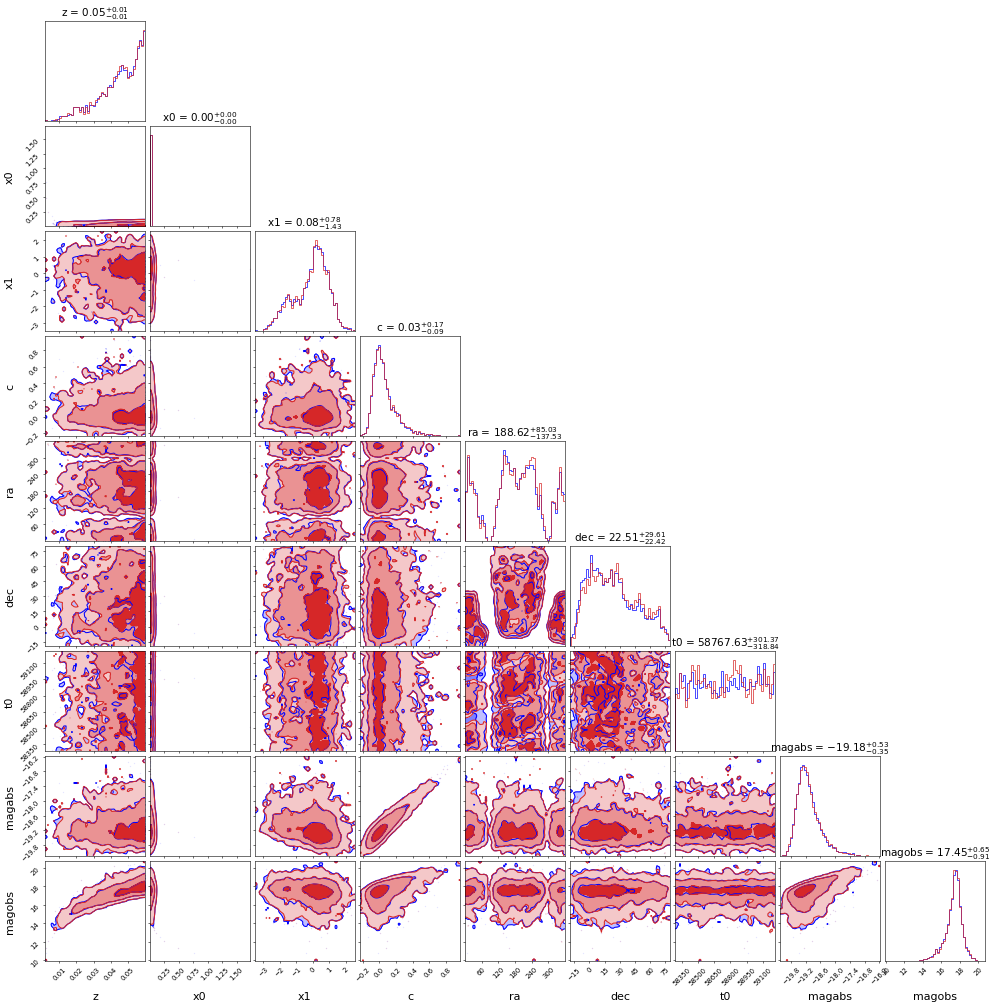

In [10]:
%matplotlib inline
fig = corner_(dset.targets.data,
    var_names=["z", "x0", "x1", "c", "ra", "dec", "t0", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"t_0",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ])
_=corner_(dset.targets.data[dset.targets.data["keep"]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "t0", "magabs", "magobs"],
    fig = fig,
    color='tab:red')


In [ ]:
%matplotlib inline
_, bins,_ =plt.hist(dset.targets.data["z"], bins =25)
_ = plt.hist(dset.targets.data[dset.targets.data["keep"]]["z"], bins=bins)
plt.title('Rate corrected')

In [12]:
with open('outdir/SN_Uchuu.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data, file)

### PETS

In [14]:
lc_pets = pandas.read_csv(
    "pets/mock_lcs.csv",
)
lc_pets.dtypes

sn           int64
name         int64
mjd        float64
flux       float64
fluxerr    float64
magsys      object
exptime    float64
valid        int64
lc           int64
band        object
mag_sky    float64
seeing     float64
zp         float64
zpsys      float64
dtype: object

In [6]:
with open("outdir/SN_Uchuu.pkl", 'rb') as f:
    data = pickle.load(f)
    lc = pickle.load(f)


In [15]:
sne = pandas.read_csv('pets/mock_sne.csv')
sne.dtypes

zhel              float64
ra                float64
dec               float64
tmax              float64
x0                float64
x1                float64
c                 float64
name                int64
sn                  int64
classification     object
comments          float64
mwebv             float64
zcmb              float64
dtype: object

In [8]:
data[data.index == 2560]

redshift     x1      c           t0          ra       dec        z  \
2560   0.04615  0.235 -0.199  58509.90625  249.100677  7.321123  0.00172   

         bgs_id   z_cosmo     magabs     mwebv    magobs        x0 template  \
2560  3817156.0  0.002103 -19.938946  0.107937  9.911569  1.732973     None   

      keep  valid  
2560  True   True

In [11]:
from astropy.table import Table
name=2560
modelpath='data/SALT_snf/'
m0file='nacl_m0_test.dat'
m1file='nacl_m1_test.dat'
clfile='nacl_color_law_test.dat'

In [12]:
def remove_outlier_fit(name,lc,sne,sigma=3):

    #Select data for specific SN
    lc_sn=lc[lc.name==name]


    #Redshift and MW extinction
    mwebv=sne[sne.name==name].mwebv.values[0]
    zsn=sne[sne.name==name].zhel.values[0]
    #Transform to Table for sncosmo
    lc_sncosmo=Table.from_pandas(lc_sn[['sn','name','mjd','flux','fluxerr','magsys','exptime','valid','lc','band','mag_sky','seeing','zp']])

    # create a model
    source = sncosmo.SALT2Source(modeldir=modelpath,m0file=m0file, m1file=m1file, clfile=clfile)
    dust = sncosmo.CCM89Dust()
    model= sncosmo.Model(source=source,effects=[dust],effect_names=['mw'],effect_frames=['obs'])

    model.set(z=zsn,mwebv=mwebv,mwr_v=3.1)  # set the model's redshift and MW
    #First fit to get a starting position for MCMC
    res, mod = sncosmo.fit_lc(lc_sncosmo, model,['t0', 'x0', 'x1', 'c'],bounds={'x0':(-0.1,10),'x1':(-5, 5),'c':(-3, 3)},phase_range=None,modelcov=False)

    residu=0
    counter=0
    progress = tqdm(desc="Recursive execution")
    while np.size(residu)>0:

        counter += 1
        if counter == 5:
            break
        residu=[]
        for i,j in enumerate(np.unique(lc_sncosmo[lc_sncosmo['valid']==1]['band'])):

            lc_band=lc_sncosmo[(lc_sncosmo['band']==j) &(lc_sncosmo['valid']==1)]


            residual=lc_band['flux']-mod.bandflux(j, lc_band['mjd'], zp=lc_band['zp'], zpsys=lc_band['magsys'])
            #3sigma clipping
            idx=np.where(np.abs(residual-np.mean(residual))/np.std(residual)>sigma)[0]


            pos_band=min(np.where(lc_sncosmo[(lc_sncosmo['valid']==1)]['band']==j)[0])				
            idx=idx+pos_band


            residu.append(idx)
        residu=np.concatenate(residu)
        lc_sncosmo['valid'][residu]=0

        res, mod = sncosmo.fit_lc(lc_sncosmo[lc_sncosmo['valid']==1], model,['t0', 'x0', 'x1', 'c'],bounds={'x0':(-0.1,10),'x1':(-5, 5),'c':(-3, 3)},phase_range=None,modelcov=False)
        progress.update()
    return lc_sncosmo


In [16]:
remove_outlier_fit(name, lc_pets, sne, sigma=3)

Recursive execution: 0it [00:00, ?it/s]

<Table length=38>
  sn   name    mjd            flux        ... band mag_sky  seeing     zp   
int64 int64  float64        float64       ... str4 float64 float64  float64 
----- ----- --------- ------------------- ... ---- ------- ------- ---------
 2560  2560  58480.56  -85.71350988109882 ... ztfr      --      -- 26.087103
 2560  2560 58480.562  168.33265702188064 ... ztfr      --      -- 26.096066
 2560  2560  58480.57 -129.81006563124893 ... ztfr      --      -- 26.116827
 2560  2560 58480.574   112.0193833061234 ... ztfr      --      -- 26.134892
 2560  2560  58481.56  -124.2219822835954 ... ztfr      --      -- 26.086456
 2560  2560 58481.566  10.374417503971545 ... ztfr      --      -- 26.115437
 2560  2560 58481.574 -23.457830394623585 ... ztfr      --      -- 26.128035
 2560  2560 58486.562   -523.824057484582 ... ztfr      --      --  26.17092
 2560  2560 58486.566  -429.1095596917551 ... ztfr      --      -- 26.174538
 2560  2560  58486.57  -438.1340103054728 ... ztfr      --      -- 26.184017
  ...   ...       ...                 ... ...  ...     ...     ...       ...
 2560  2560  58506.54   1852204.795570816 ... ztfg      --      -- 26.216309
 2560  2560 58509.492   1089060.021737763 ... ztfr      --      -- 25.855602
 2560  2560 58509.523  1942897.7306521167 ... ztfg      --      -- 26.199501
 2560  2560 58512.527   750232.8752047571 ... ztfr      --      -- 25.450132
 2560  2560 58512.543   68347.07585826467 ... ztfg      --      --  22.60081
 2560  2560 58539.426  12933.171012342396 ... ztfi      --      --   22.1415
 2560  2560  58543.48  196072.97084438385 ... ztfr      --      --    25.286
 2560  2560 58543.523  221537.44822384955 ... ztfg      --      -- 26.083702
 2560  2560 58556.543  131022.75405140278 ... ztfi      --      -- 25.557848
 2560  2560  58557.46   168695.7052117114 ... ztfg      --      -- 26.241108

In [26]:
with open("outdir/test.pkl", 'wb') as f:
    pickle.dump(data[data.index == 2560], f)
    pickle.dump(lc[np.array(list(map(lambda x : x[0],lc.index))) == 2560], f)

In [9]:
dset=skysurvey.DataSet(data=lc)
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(data))

2024-06-25 08:30:47,993 INFO Loading ZTF survey
2024-06-25 08:30:58,337 INFO Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


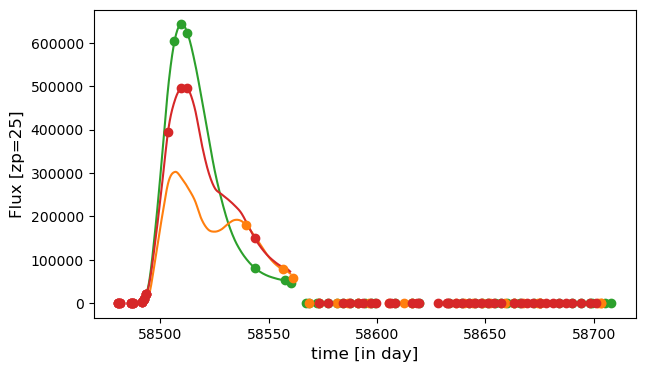

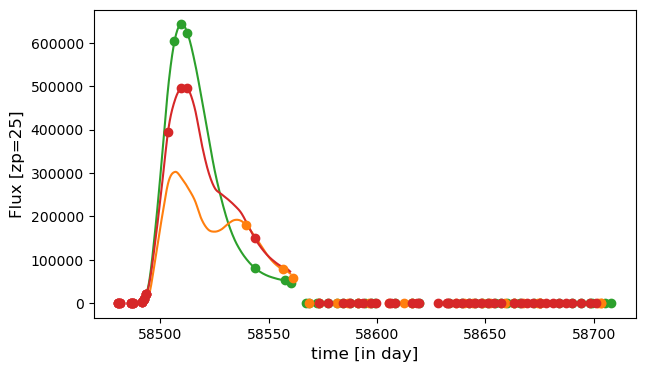

In [117]:
dset.show_target_lightcurve(index=2560, phase_window=[-100,200], format_time=False)

In [11]:
    fixed = {
        "z": dset.targets.data.loc[2560, "z"],
        "mwebv": dset.targets.data.loc[2560, "mwebv"],
        "mwr_v": [3.1],
    }

    guess = {
        "t0": dset.targets.data.loc[2560, "t0"],
        "c": dset.targets.data.loc[2560, "c"],
        "x0": dset.targets.data.loc[2560, "x0"],
        "x1": dset.targets.data.loc[2560, "x1"],
    }
    bounds = {
        "t0": [[dset.targets.data.loc[2560, "t0"]-15, dset.targets.data.loc[2560, "t0"]+30]],
        "c": [[-3, 3]],
        "x0": [[-.1, 10]],
        "x1": [[-5, 5]],
    }

    params = dict(phase_fitrange=[-40, 80], maxcall=10000, modelcov=False)

    results, meta = dset.fit_lightcurves(
        source=dset.targets._template._sncosmo_model,
        index=[2560],
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
        **params,
    )


In [14]:
results

value     error        cov_t0        cov_x0        cov_x1  \
2560 z          0.001720       NaN           NaN           NaN           NaN   
     t0     58509.623485  0.000038  1.408642e-09  3.068294e-15  1.923605e-15   
     x0         1.739666  0.000496  3.068294e-15  2.460537e-07  1.237818e-09   
     x1        -0.022483  0.000930  1.923605e-15  1.237818e-09  8.643351e-07   
     c         -0.201054  0.000302 -2.283649e-15 -1.217441e-07 -6.510978e-08   
     mwebv      0.107937       NaN           NaN           NaN           NaN   

                   cov_c        truth  
2560 z               NaN      0.00172  
     t0    -2.283649e-15  58509.90625  
     x0    -1.217441e-07     1.732973  
     x1    -6.510978e-08        0.235  
     c      9.148430e-08       -0.199  
     mwebv           NaN     0.107937

In [328]:
sne = pandas.read_csv("pets/mock_sne.csv")

In [350]:
name=2560

In [354]:
from astropy.table import Table

In [355]:
lc_sn=lc[lc.name==name]

#Redshift and MW extinction
mwebv=sne[sne.name==name].mwebv.values[0]
zsn=sne[sne.name==name].zhel.values[0]
#Transform to Table for sncosmo
lc_sncosmo=Table.from_pandas(lc_sn[['sn','name','mjd','flux','fluxerr','magsys','exptime','valid','lc','band','mag_sky','seeing','zp']])


In [366]:
modelpath='data/SALT_snf/'
m0file='nacl_m0_test.dat'
m1file='nacl_m1_test.dat'
clfile='nacl_color_law_test.dat'

source = sncosmo.SALT2Source(modeldir=modelpath,m0file=m0file, m1file=m1file, clfile=clfile)
dust = sncosmo.CCM89Dust()
model= sncosmo.Model(source=source,effects=[dust],effect_names=['mw'],effect_frames=['obs'])

model.set(z=zsn,mwebv=mwebv,mwr_v=3.1)  # set the model's redshift and MW
#First fit to get a starting position for MCMC
res, mod = sncosmo.fit_lc(lc_sncosmo, model,['t0', 'x0', 'x1', 'c'],bounds={'x0':(-0.1,10),'x1':(-5, 5),'c':(-3, 3)},phase_range=None,modelcov=False)


In [377]:
sigma=3
counter=0
progress = tqdm(desc="Recursive execution", leave=False)
while np.size(residu)>0:

    counter += 1
    if counter == 5:
        break
    residu=[]
    for i,j in enumerate(np.unique(lc_sncosmo[lc_sncosmo['valid']==1]['band'])):

        lc_band=lc_sncosmo[(lc_sncosmo['band']==j) &(lc_sncosmo['valid']==1)]


        residual=lc_band['flux']-mod.bandflux(j, lc_band['mjd'], zp=lc_band['zp'], zpsys=lc_band['magsys'])
        #3sigma clipping
        idx=np.where(np.abs(residual-np.mean(residual))/np.std(residual)>sigma)[0]


        pos_band=min(np.where(lc_sncosmo[(lc_sncosmo['valid']==1)]['band']==j)[0])				
        idx=idx+pos_band


        residu.append(idx)
    residu=np.concatenate(residu)
    lc_sncosmo['valid'][residu]=0

    res, mod = sncosmo.fit_lc(lc_sncosmo[lc_sncosmo['valid']==1], model,['t0', 'x0', 'x1', 'c'],bounds={'x0':(-0.1,10),'x1':(-5, 5),'c':(-3, 3)},phase_range=None,modelcov=False)		
    progress.update()


Recursive execution: 0it [00:00, ?it/s]

<ErrorbarContainer object of 3 artists>

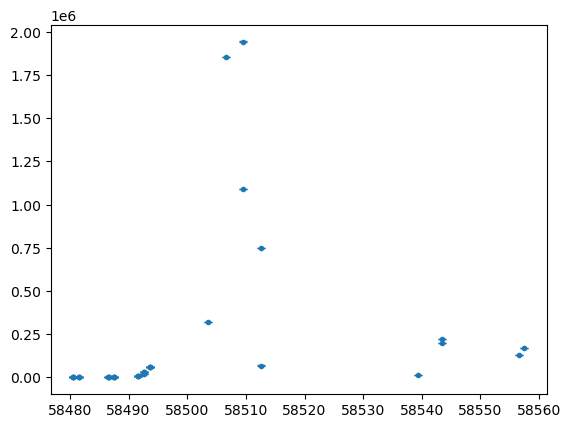

In [362]:
plt.errorbar(lc_sncosmo['mjd'], lc_sncosmo['flux'], yerr=lc_sncosmo['fluxerr'], linestyle='', marker=".", capsize=3)

In [348]:
sne.loc[2560]

zhel                0.00172
ra                249.10068
dec                7.321123
tmax              58509.906
x0                 1.732973
x1                    0.235
c                    -0.199
name                   2560
sn                     2560
classification         SNIa
comments                NaN
mwebv              0.070566
zcmb               0.001887
Name: 2560, dtype: object

In [ ]:
sne[sne["valid"]].index

In [ ]:
sne = sne.rename({"zhel": "z"}, axis=1)

In [ ]:
sne[sne["valid"]]

In [ ]:
dset = skysurvey.DataSet(lc[lc["valid"]].rename({"mjd": "time"}, axis=1))
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(sne))

In [ ]:
index = np.where(sne["valid"])[0]
index

In [ ]:
sne_ = dset.targets.data.loc[index].copy()

fixed = {
    "z": sne_["z"],
    "t0": sne_["tmax"],
}

guess = {
    "c": sne_["c"],
    "x0": sne_["x0"],
    "x1": sne_["x1"],
}
bounds = {
    "c": sne_["c"].apply(lambda x: [-0.8, 1.0]),
    "x0": sne_["x0"].apply(lambda x: [-0.8, 0.8]),
    "x1": sne_["x1"].apply(lambda x: [-6, 6]),
}

params = dict(phase_fitrange=[-40, 130], maxcall=10000)

In [ ]:
results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=index,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
    **params,
)

In [ ]:
results

In [ ]:
success = [meta[(i, "success")] for i in index]

In [ ]:
dset.targets.data["converged"] = False

In [ ]:
for i in index:
    dset.targets.data.loc[i, "converged"] = meta[(i, "success")]

In [ ]:
dset.targets.data

In [ ]:
with open("data/SN_Uchuu_pets.pkl", "wb") as f:
    pickle.dump(dset.data, f)
    pickle.dump(dset.targets.data, f)
    pickle.dump(results, f)
    pickle.dump(meta, f)

### Selection cut

In [ ]:
np.sum(dset.targets.data["good"])

In [ ]:
full, bins, _ = plt.hist(
    dset.targets.data[dset.targets.data["keep"]]["magobs"], bins=50
)
surv, _, _ = plt.hist(dset.targets.data[dset.targets.data["good"]]["magobs"], bins=bins)
plt.figure()
from scipy.signal import filtfilt

plt.plot((bins[1:] + bins[:-1]) / 2, filtfilt([1 / 5] * 5, 1, surv / full))

In [ ]:
_, bins = np.histogram(dset.targets.data["magobs"], bins=100)
kept, _, _ = plt.hist(dset.targets.data[dset.targets.data["keep"]]["magobs"], bins=bins)
good, _, _ = plt.hist(dset.targets.data[dset.targets.data["good"]]["magobs"], bins=bins)

In [ ]:
from scipy.stats import gaussian_kde

kept_kde = gaussian_kde(
    dset.targets.data[dset.targets.data["keep"]]["magobs"], bw_method=0.3
)
good_kde = gaussian_kde(
    dset.targets.data[dset.targets.data["good"]]["magobs"], bw_method=0.3
)

mag = np.linspace(12, 22, 1000)
plt.plot(mag, kept_kde(mag) * np.sum(dset.targets.data["keep"]))
plt.plot(mag, good_kde(mag) * np.sum(dset.targets.data["good"]))

In [ ]:
mid = (bins[:-1] + bins[1:]) / 2
mid[kept > 0][[0, -1]]

In [ ]:
def sigmoid(x, alpha, beta, A=1):
    return A / (1 + np.exp(alpha * (x - beta)))

In [ ]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(
    sigmoid,
    mag,
    good_kde(mag)
    * np.sum(dset.targets.data["good"])
    / (kept_kde(mag) * np.sum(dset.targets.data["keep"])),
    p0=[9.532465, 19.689556, 1.0],
)

In [ ]:
popt

In [ ]:
plt.plot(
    mag,
    good_kde(mag)
    * np.sum(dset.targets.data["good"])
    / (kept_kde(mag) * np.sum(dset.targets.data["keep"])),
)
plt.plot(np.linspace(12, 24, 100), sigmoid(np.linspace(12, 24, 100), *popt), "r")

### LC fit

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)
dset = skysurvey.DataSet(lc)
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(data))

In [ ]:
index = dset_sanitize_and_filter(dset)

In [ ]:
results, meta, models = fit_lc(
    dset, index, savefile="data/SN_Uchuu_modelcov.pkl", modelcov=True
)

In [ ]:
success = [meta[(i, "success")] for i in index]

In [ ]:
sum(success)

In [ ]:
dset.targets.data["converged"] = False

In [ ]:
for i in index:
    dset.targets.data.loc[i, "converged"] = meta[(i, "success")]

In [ ]:
with open("data/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)
dset = skysurvey.DataSet(lc)
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(data))

In [ ]:
index = data[data["converged"]].index

In [ ]:
better_results = pandas.DataFrame(
    {
        **{
            col: np.array(res_sn["value"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
        **{
            "err_" + col: np.array(res_sn["error"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
        **{
            "delta_"
            + col: np.array(res_sn["value"].loc[map(lambda x: (x, col), index)])
            - np.array(res_sn["truth"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
    },
    index=index,
)

In [ ]:
res_sn = res_sn.loc[index]

In [ ]:
from astropy.time import Time


def plot_lc(dset, i, better_results=None, fig=None, **kwargs):
    _ = dset.show_target_lightcurve(index=i, s=8, fig=fig, **kwargs)
    plt.ylim(-200)
    target = dset.targets.data.loc[i]
    plt.axvline(Time(target["t0"], format="mjd").datetime, label=r"True $t_0$")
    if better_results:
        plt.axvline(
            Time(better_results.loc[i]["t0"], format="mjd").datetime,
            linestyle="--",
            c="darkblue",
            alpha=0.4,
            label=r"Fitted $t_0$",
        )

        plt.axvline(
            Time(
                better_results.loc[i]["t0"] + better_results.loc[i]["err_t0"],
                format="mjd",
            ).datetime,
            c="k",
            linestyle="dotted",
            label=r"$\sigma_{t_0}$",
        )
        plt.axvline(
            Time(
                better_results.loc[i]["t0"] - better_results.loc[i]["err_t0"],
                format="mjd",
            ).datetime,
            c="k",
            linestyle="dotted",
        )

    plt.xlim(
        Time(target["t0"] - 50, format="mjd").datetime,
        Time(target["t0"] + 100, format="mjd").datetime,
    )
    plt.legend()
    plt.title(f"Target {i}")

In [ ]:
goods = (
    (better_results["err_c"] < jnp.sqrt(0.07))
    & (abs(better_results["c"]) < 0.3)
    & (abs(better_results["x1"]) + better_results["x1"] < 5)
)

In [ ]:
_ = corner_(better_results[data[data["good"]]["converged"] & goods])

In [ ]:
def dset_from_res(better_results):
    data_r = (
        data.join(better_results[["x1", "c", "t0", "x0"]], lsuffix="_true")
        .loc[index]
        .copy()
    )
    data_r = data_r[dset.targets.get_template_columns()].copy()
    dset_r = skysurvey.DataSet(data=lc.loc[index])
    dset_r.set_survey(extract_ztf())
    dset_r.set_targets(SNeIa_full_bgs.from_data(data_r))
    return dset_r

In [ ]:
dset_r = dset_from_res(better_results)

In [ ]:
with open("data/SN_Uchuu.pkl", "rb") as f:
    lc_ = pickle.load(f)
    data_ = pickle.load(f)
    res_sn_ = pickle.load(f)

index = data_[data_["good"]].index[:800]
better_results_old = pandas.DataFrame(
    {
        **{
            col: np.array(res_sn_["value"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
        **{
            "err_" + col: np.array(res_sn_["error"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
        **{
            "delta_"
            + col: np.array(res_sn_["value"].loc[map(lambda x: (x, col), index)])
            - np.array(res_sn_["truth"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
    },
    index=index,
)

dset_old_fit = dset_from_res(better_results_old)

In [ ]:
def plot_lc_reconstruct(dset_r, index, fig=None, **kwargs):
    params = dict(
        colors=["red", "green", "yellow"],
        linestyle="dashed",
        linewidth=1,
        time_range=[-20, 50],
        npoints=500,
        zp=25,
        zpsys="ab",
        format_time=True,
        t0_format="mjd",
        in_mag=False,
        invert_mag=True,
        label="fit",
    )
    params.update(kwargs)
    _ = dset_r.targets.get_target_template(index).show_lightcurve(
        ["ztfr", "ztfg", "ztfi"], params={}, ax=plt.gca(), **params
    )
    plt.legend()

### Extended Salt2

In [ ]:
from skysurvey import DataSet

with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)

In [ ]:
data

In [ ]:
snia = SNeIa_full_bgs.from_data(data)

In [ ]:
data

In [ ]:
data["magobs"] = skysurvey.Transient.magabs_to_magobs(
    snia, z=data["z_cosmo"], magabs=data["magabs"]
)

In [ ]:
data["x0"] = skysurvey.Transient.magobs_to_amplitude(
    snia, magobs=data["magobs"], param_name="x0"
)

In [ ]:
data

In [ ]:
dset = skysurvey.DataSet.from_targets_and_survey(
    SNeIa_full_bgs.from_data(data), extract_ztf()
)

In [ ]:
index = dset_sanitize_and_filter(dset)

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "wb") as f:
    pickle.dump(data, f)

In [ ]:
import numpy as np
import pickle
from edris.tools import linear_interpolation_matrix, restrict
from edris.models import likelihood, binned_cosmo, sn1a_model
from edris.minimize import tncg
import sncosmo
from scipy.interpolate import interp1d
from astropy.constants import c
from scipy.integrate import quad
from astropy.cosmology import Planck18 as cosmo
from scipy.optimize import curve_fit

try:
    from tqdm.auto import tqdm
except:
    tqdm = lambda x: x

In [ ]:
idx = index[13]
idx

In [ ]:
_ = dset.show_target_lightcurve(index=idx, phase_window=[-40, 80])

In [ ]:
fixed = {
    "z": dset.targets.data.loc[idx, "z"],
    "mwebv": dset.targets.data.loc[idx, "mwebv"],
    "mwr_v": [3.1],
}

guess = {
    "t0": dset.targets.data.loc[idx, "t0"],
    "c": dset.targets.data.loc[idx, "c"],
    "x0": dset.targets.data.loc[idx, "x0"],
    "x1": dset.targets.data.loc[idx, "x1"],
}
bounds = {
    "t0": [dset.targets.data.loc[idx, "t0"] + np.array([-15, 30])],
    "c": [[-3, 3]],
    "x0": [[-0.1, 10]],
    "x1": [[-5, 5]],
}

params = dict(phase_fitrange=[-40, 80], maxcall=10000, modelcov=True)
dset.fit_lightcurves(
    source=dset.targets._template._sncosmo_model,
    index=[idx],
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
    **params,
)

In [ ]:
fixed = {
    "z": dset.targets.data.loc[index, "z"],
    "mwebv": dset.targets.data.loc[index, "mwebv"],
    "mwr_v": [3.1] * len(index),
}

guess = {
    "t0": dset.targets.data.loc[index, "t0"],
    "c": dset.targets.data.loc[index, "c"],
    "x0": dset.targets.data.loc[index, "x0"],
    "x1": dset.targets.data.loc[index, "x1"],
}
bounds = {
    "t0": dset.targets.data.loc[index, "t0"].apply(lambda x: np.array([-15, 30]) + x),
    "c": [[-3, 3]] * len(index),
    "x0": [[-0.1, 10]] * len(index),
    "x1": [[-5, 5]] * len(index),
}

params = dict(phase_fitrange=[-40, 80], maxcall=10000, modelcov=True)
results, meta = dset.fit_lightcurves(
    source=dset.targets._template._sncosmo_model,
    index=index,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
    **params,
)

In [ ]:
index = data[data["good"]].index

In [ ]:
dset.targets.data["converged"] = False

In [ ]:
for i in index:
    dset.targets.data.loc[i, "converged"] = meta[(i, "success")]

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "wb") as f:
    pickle.dump(dset.data, f)
    pickle.dump(dset.targets.data, f)
    pickle.dump(results, f)
    pickle.dump(meta, f)

In [ ]:
results, meta

### Except it's Abacus

In [ ]:
snia = SNeIa_full_bgs(filename="Abacus.csv")

In [ ]:
survey = extract_ztf()

_ = snia.draw(
    tstart=survey.date_range[0], tstop=survey.date_range[1], inplace=True, zmax=0.06
)

dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

In [ ]:
index = dset_sanitize_and_filter(dset)

In [ ]:
def plot_lc(dset, i, better_results=None, **kwargs):
    params = dict(phase_window=[-40, 80])
    params.update(kwargs)
    _ = dset.show_target_lightcurve(index=i, s=8, **params)
    plt.ylim(-200)
    target = dset.targets.data.loc[i]
    plt.axvline(Time(target["t0"], format="mjd").datetime, label=r"$t_0$")
    if better_results:
        plt.axvline(
            Time(better_results.loc[i]["t0"], format="mjd").datetime,
            linestyle="--",
            c="darkblue",
            alpha=0.4,
            label=r"Fitted $t_0$",
        )

        plt.axvline(
            Time(
                better_results.loc[i]["t0"] + better_results.loc[i]["err_t0"],
                format="mjd",
            ).datetime,
            c="k",
            linestyle="dotted",
            label=r"$\sigma_{t_0}$",
        )
        plt.axvline(
            Time(
                better_results.loc[i]["t0"] - better_results.loc[i]["err_t0"],
                format="mjd",
            ).datetime,
            c="k",
            linestyle="dotted",
        )

    plt.legend()
    plt.title(f"Target {i}")

In [ ]:
plot_lc(dset, index[1812])

In [ ]:
fit_lc(dset, index, savefile="outdir/SN_Abacus.pkl")

### Fit with nacl

In [272]:
from nacl.train import TrainSALT2Like

from nacl.dataset import TrainingDataset
from lemaitre import bandpasses
from nacl.models.salt2 import SALT2Like
from nacl.specutils import clean_and_project_spectra


In [ ]:
filterlib = bandpasses.get_filterlib()

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)

In [ ]:
data["sn"] = data.index
data["good"] = data["good"].apply(lambda x: int(x))
data["keep"] = data["keep"].apply(lambda x: int(x))
sn_data = data.drop(columns=["converged", "used_edris", "calc_z_cosmo"]).rename(
    columns={"t0": "tmax", "good": "valid"}
)

In [ ]:
lc_data = lc.rename(columns={"detected": "valid", "time": "mjd"})
lc_data = lc_data.replace({"ztfi": "ztf::I", "ztfr": "ztf::r", "ztfg": "ztf::g"})
lc_data["sn"] = lc.index.get_level_values("index")
lc_data['valid'] = lc_data['valid'].apply(lambda x : int(x))
lc_data['lc'] = lc_data['sn'].astype(str) + '-' + lc_data['band']
lc_data['seeing'] = 0.
lc_data['x'] = 0.
lc_data['y'] = 0.
lc_data['sensor_id'] = 0
lc_data['mag_sky'] = 0.
lc_data['exptime'] = 0.
lc_data['magsys'] = 0.
lc_data = lc_data.reset_index(drop=True)

In [ ]:
spectra = pandas.read_csv("outdir/SN_Uchuu_spectra.csv", index_col=0).rename(columns={'snid':'sn', 'time':'mjd'})
# spectra = data_mock.rename(columns={'snid':'sn', 'time':'mjd'})

spectra.sn = spectra.sn.apply(lambda x : int(x))

spectra = spectra.drop(columns=['x0','x1','c','t0','mwebv','z'])

spectra['i_basis'] = 0

In [ ]:
for i in tqdm(sn_data[sn_data.valid==0].index):
    lc_data.loc[lc_data[lc_data.sn == sn_data.loc[i, 'sn']].index, 'valid'] = 0
    spectra.loc[spectra[spectra.sn == sn_data.loc[i, 'sn']].index, 'valid'] = 0

In [ ]:
spectra.loc[spectra[spectra.flux_true==0].index,'valid'] = 0

In [ ]:
del lc, data

In [ ]:
tds = TrainingDataset(sne=sn_data.to_records(),
                      lc_data=lc_data.to_records(),
                      spec_data=spectra.to_records(),
                      filterlib=filterlib)

In [ ]:
tds

In [ ]:
tds.compress()

In [ ]:
model = SALT2Like(tds)

In [ ]:
projected_spectra, in_error = clean_and_project_spectra(tds, model.basis.bx)

In [ ]:
tds = TrainingDataset(tds.sn_data.nt, lc_data=tds.lc_data.nt,
                           spec_data=np.rec.array(np.hstack(projected_spectra)),
                           basis=model.basis.bx,
                           filterlib=filterlib)


In [ ]:
tds.plot_sample()
tds.plot_coverage()

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='False'

In [ ]:
trainer = TrainSALT2Like(tds, variance_model='sn_local_snake')

In [ ]:
trainer.train_salt2_model()

In [ ]:
trainer.save('outdir/nacl_Uchuu.pkl')

In [297]:
trainer = TrainSALT2Like.load('outdir/nacl_Uchuu.pkl')

In [298]:
pars_trained = trainer.log[-1].pars
v_trained = trainer.log[-1].v

In [ ]:
cov_matrix = trainer.log[-1].minz.get_cov_matrix()[0]

In [ ]:
np.savez_compressed('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/nacl_cov.npz', cov_matrix.toarray())

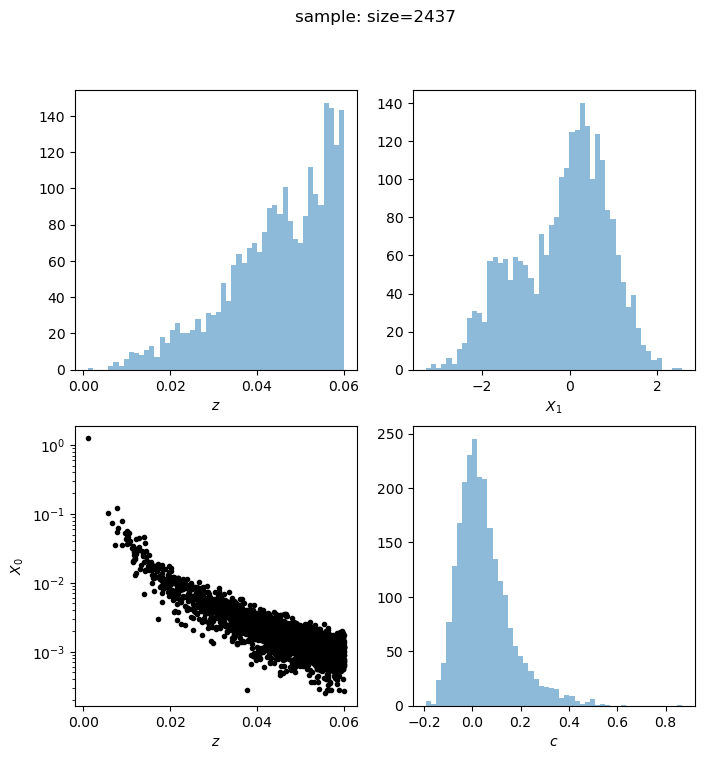

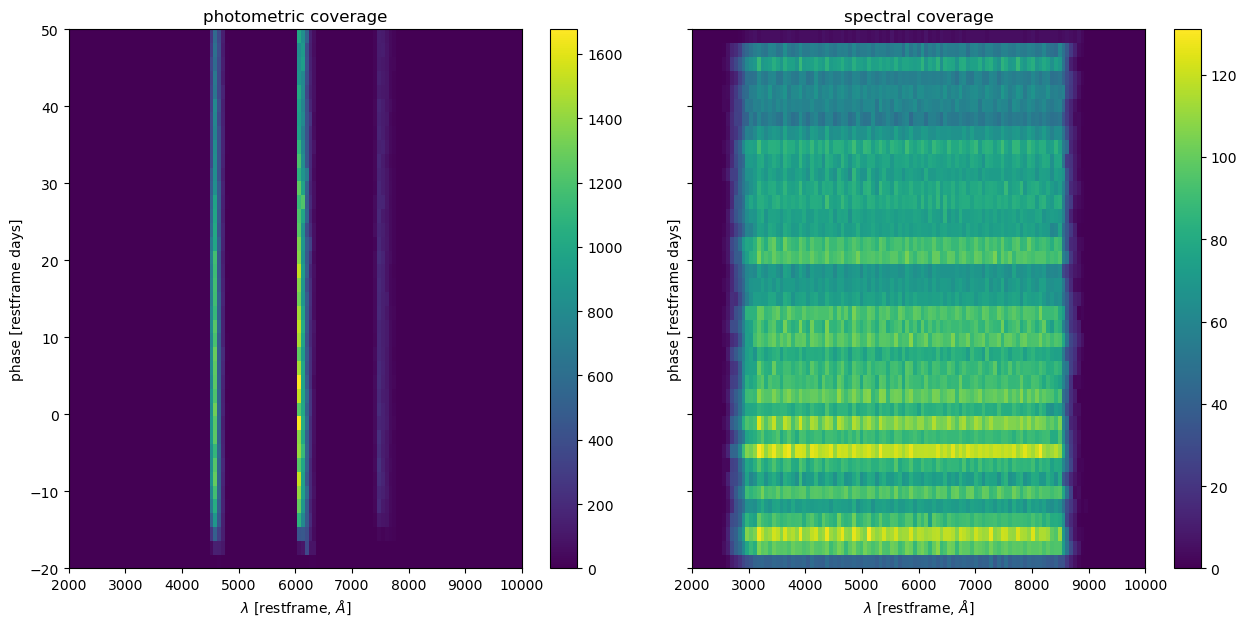

In [311]:
trainer.tds.plot_sample()
trainer.tds.plot_coverage()

In [275]:
with np.load('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/nacl_cov.npz') as data:
    cov_matrix=data['arr_0']

In [276]:
n = len(trainer.tds.sn_data)

In [277]:
cov_r = cov_matrix[:4*n, :4*n].copy()

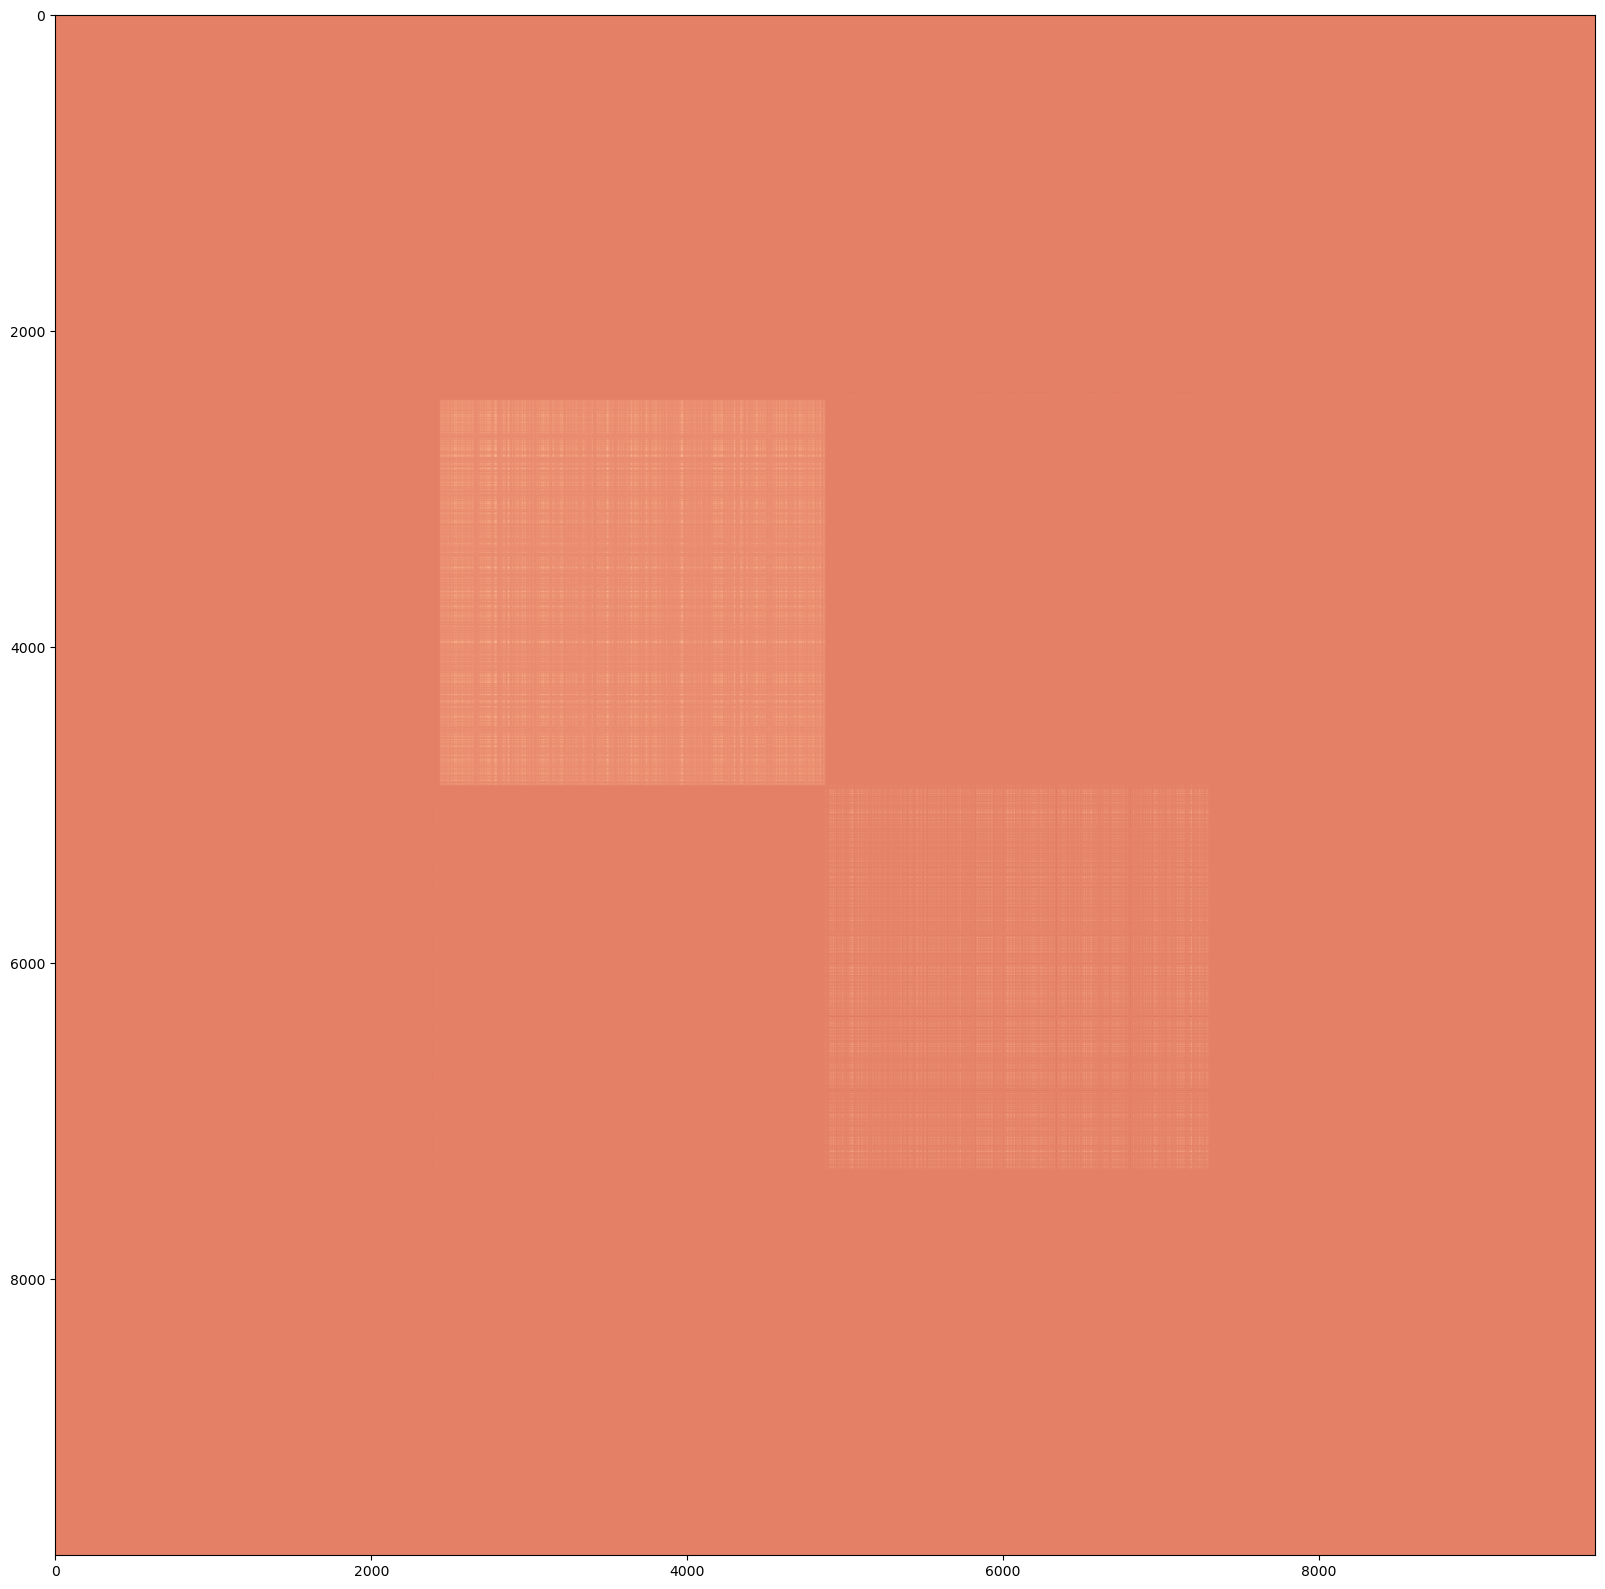

In [278]:
plt.figure(figsize=(20,20))
plt.imshow(cov_r, norm='symlog', cmap='RdBu')

In [279]:
from scipy.sparse import csc_matrix
sigma = csc_matrix(jnp.diag(1/jnp.sqrt(jnp.diag(cov_r))))

In [280]:
corr_matrix = (sigma @ csc_matrix(cov_r) @ sigma).toarray()

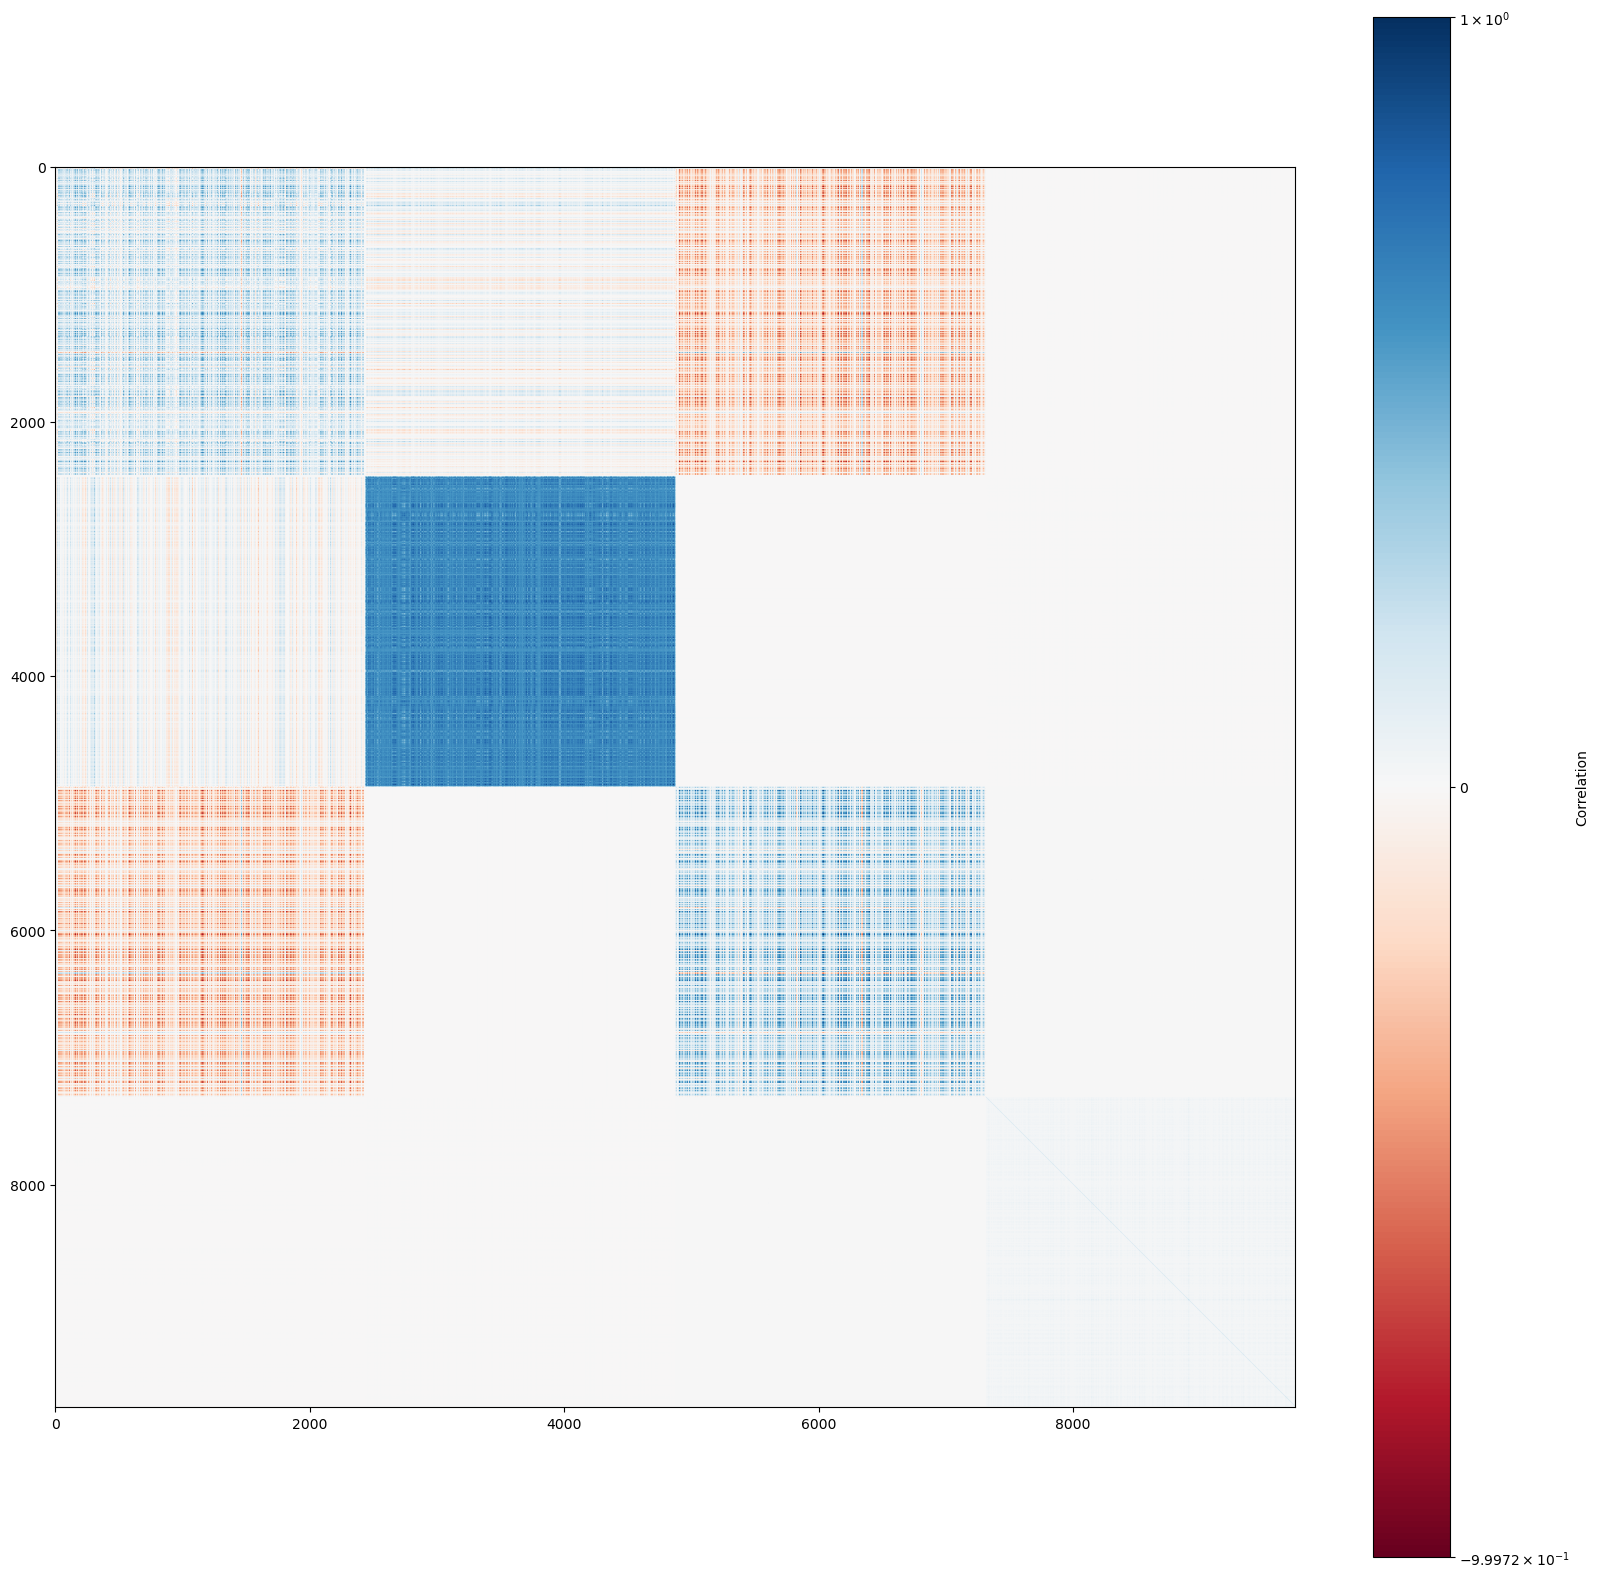

In [281]:
plt.figure(figsize=(20,20))
im = plt.imshow(corr_matrix, cmap='RdBu', norm='symlog')
plt.colorbar(im, label='Correlation')
plt.savefig('../figures/nacl_corr.png')

In [300]:
perm = jnp.argsort(trainer.tds.sn_data.z)
cplt_perm = jnp.hstack([*[perm+k*n for k in range(4)], *[i for i in range(4*n,corr_matrix.shape[0])]])

In [301]:
corr_sort=corr_matrix[cplt_perm,:][:,cplt_perm]

Text(0.5, 0, 'z')

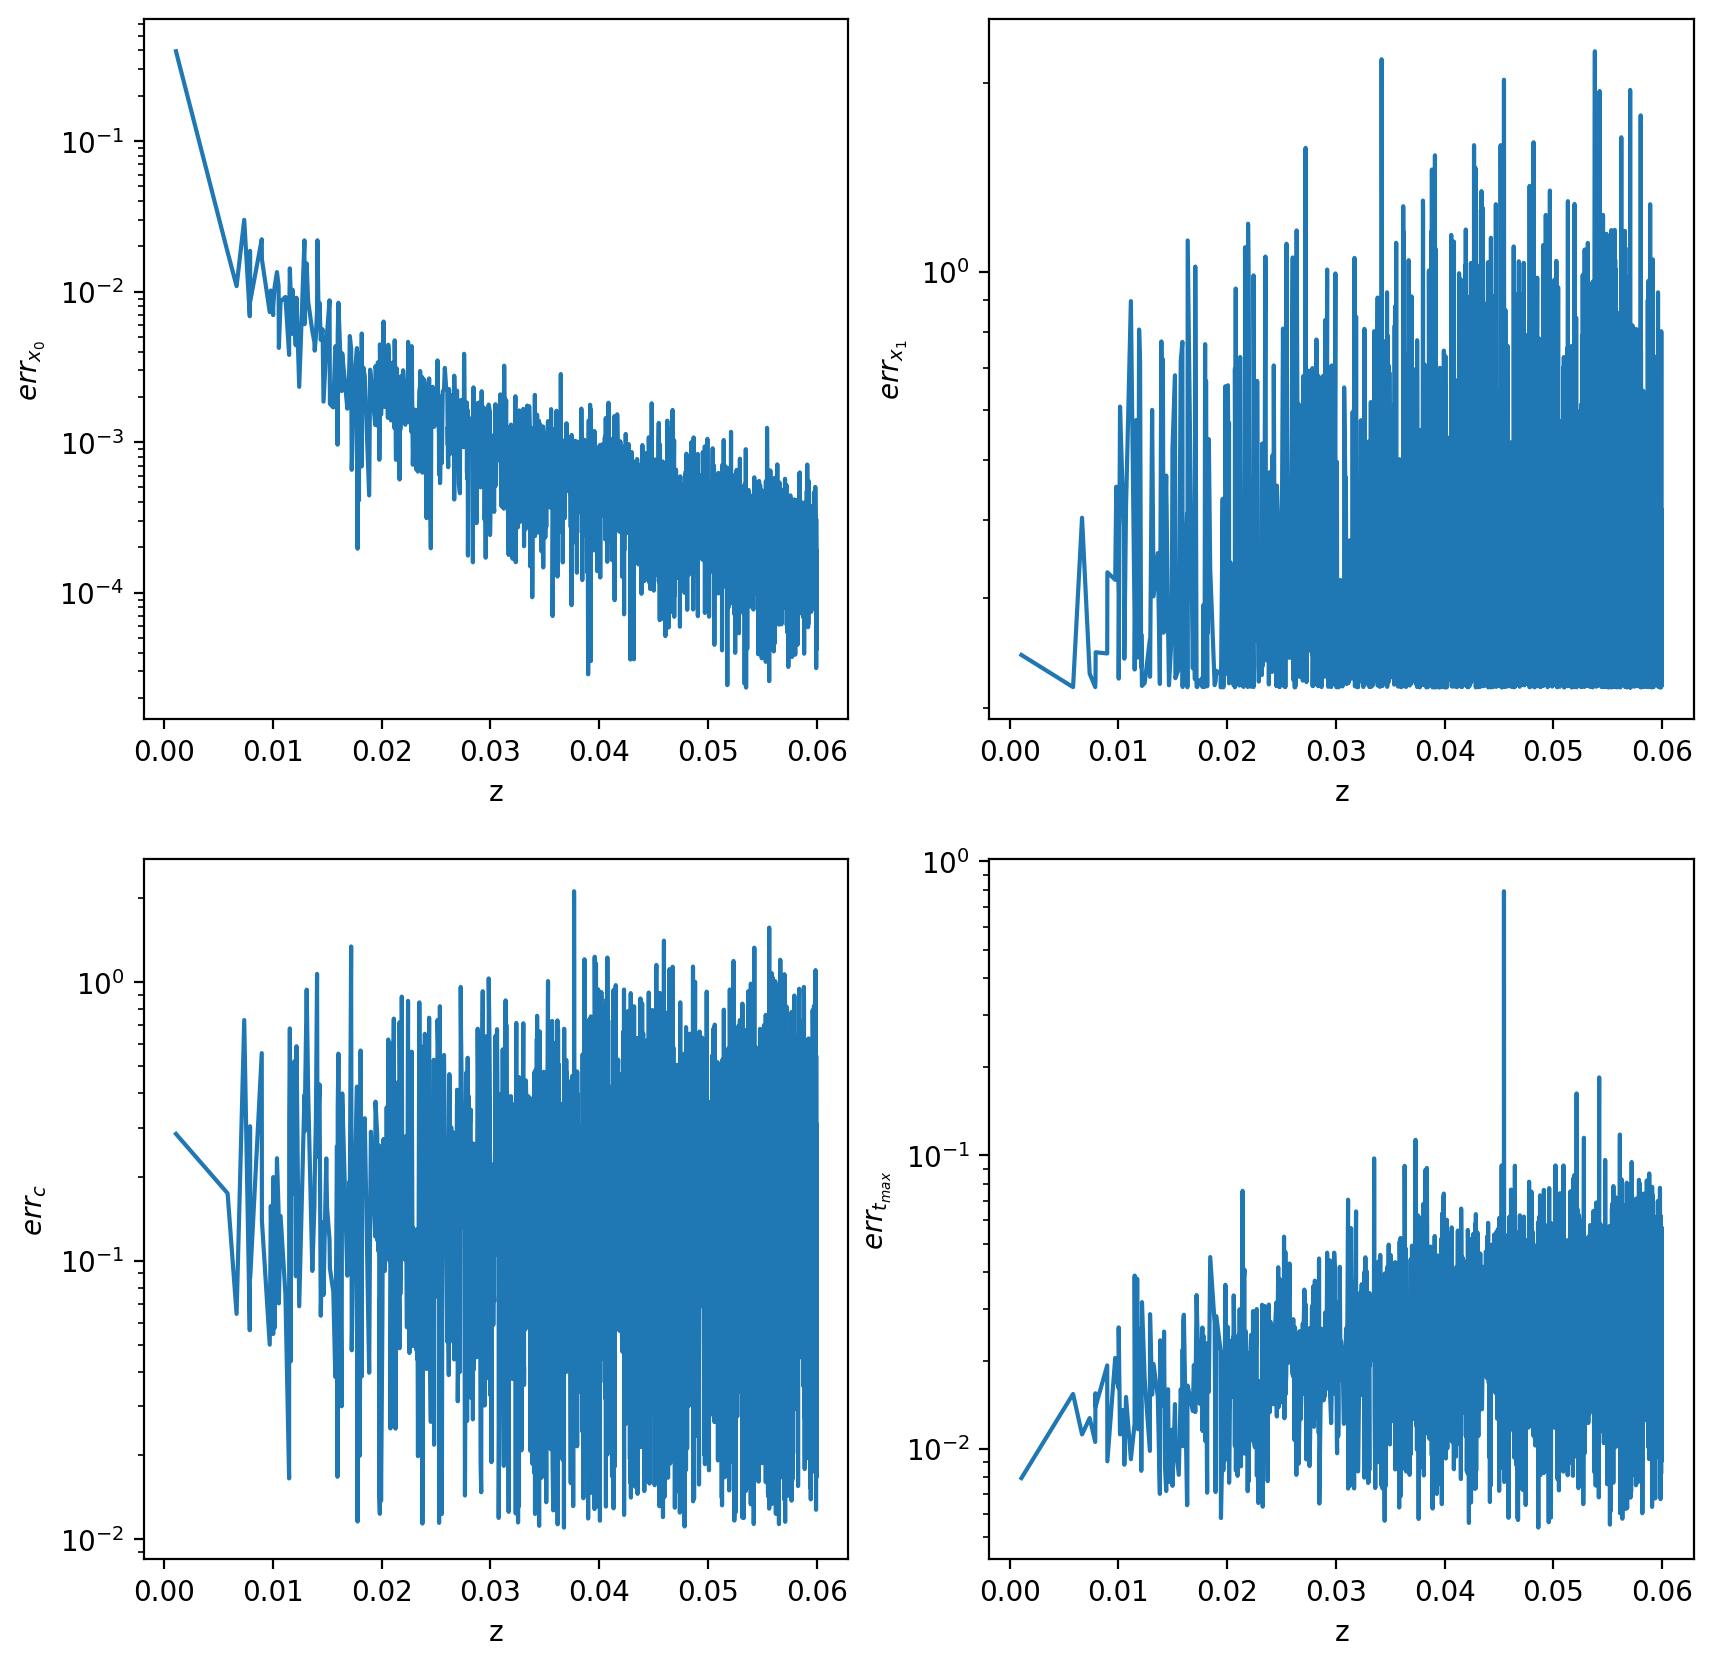

In [312]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=200)
ax1.plot(jnp.sort(trainer.tds.sn_data.z), jnp.sqrt(jnp.diag(cov_r[:n,:n])[perm]))
ax1.set_yscale("log")
ax1.set_ylabel("$err_{x_0}$")
ax1.set_xlabel("z")

ax2.plot(jnp.sort(trainer.tds.sn_data.z), jnp.sqrt(jnp.diag(cov_r[n:2*n,n:2*n])[perm]))
ax2.set_yscale("log")
ax2.set_ylabel("$err_{x_1}$")
ax2.set_xlabel("z")

ax3.plot(jnp.sort(trainer.tds.sn_data.z), jnp.sqrt(jnp.diag(cov_r[2*n:3*n,2*n:3*n])[perm]))
ax3.set_yscale("log")
ax3.set_ylabel("$err_c$")
ax3.set_xlabel("z")

ax4.plot(jnp.sort(trainer.tds.sn_data.z), jnp.sqrt(jnp.diag(cov_r[3*n:4*n,3*n:4*n])[perm]))
ax4.set_yscale("log")
ax4.set_ylabel("$err_{t_{max}}$")
ax4.set_xlabel("z")


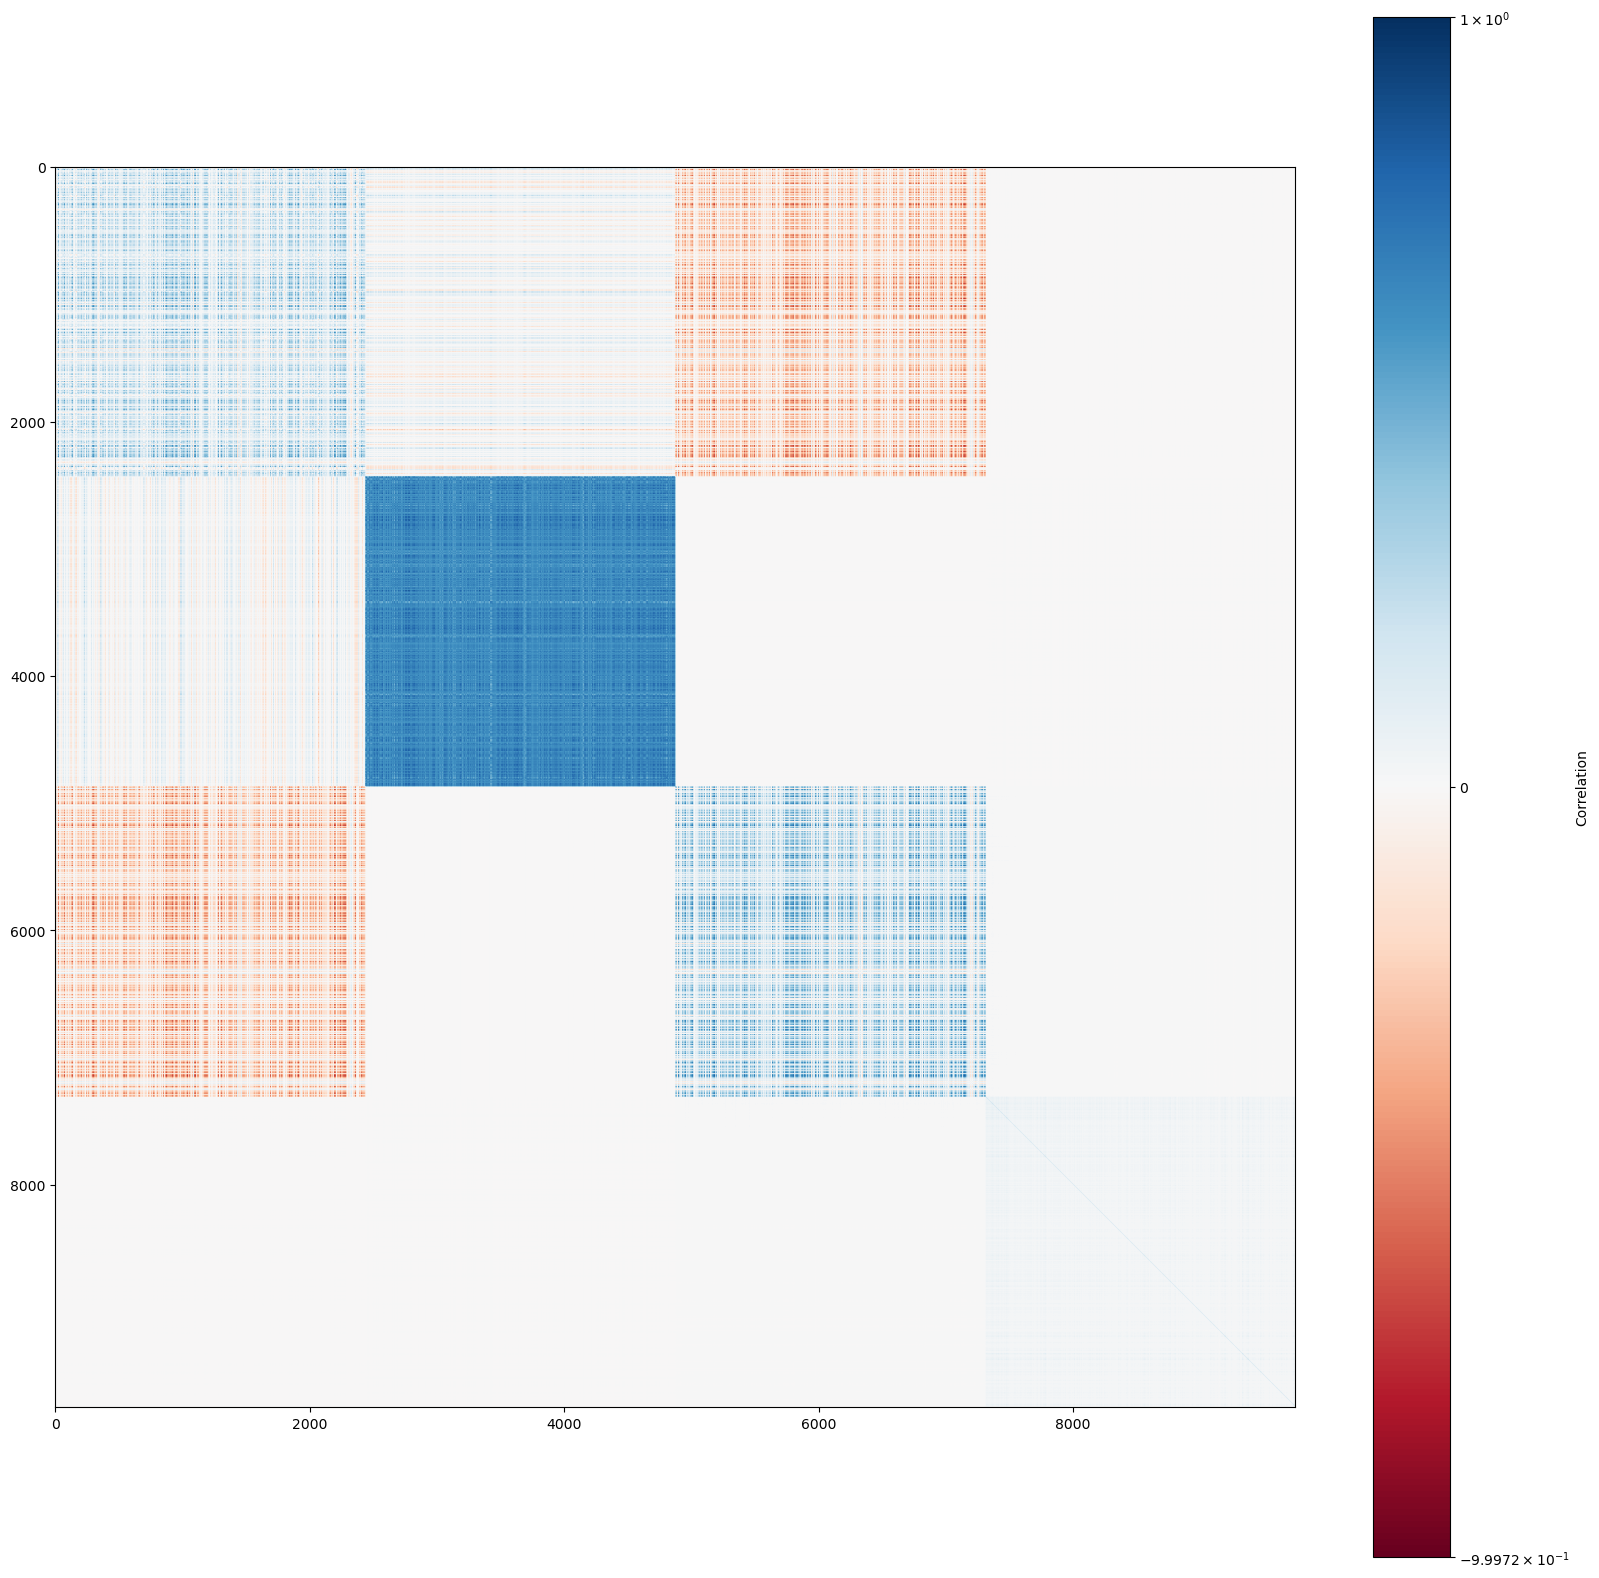

In [306]:
plt.figure(figsize=(20,20))
im = plt.imshow(corr_matrix[cplt_perm,:][:,cplt_perm], norm='symlog', cmap='RdBu')
plt.colorbar(im, label='Correlation')
plt.savefig('../figures/nacl_corr_sorted.png')

Text(0.5, 1.0, 'Reconstructed distribution')

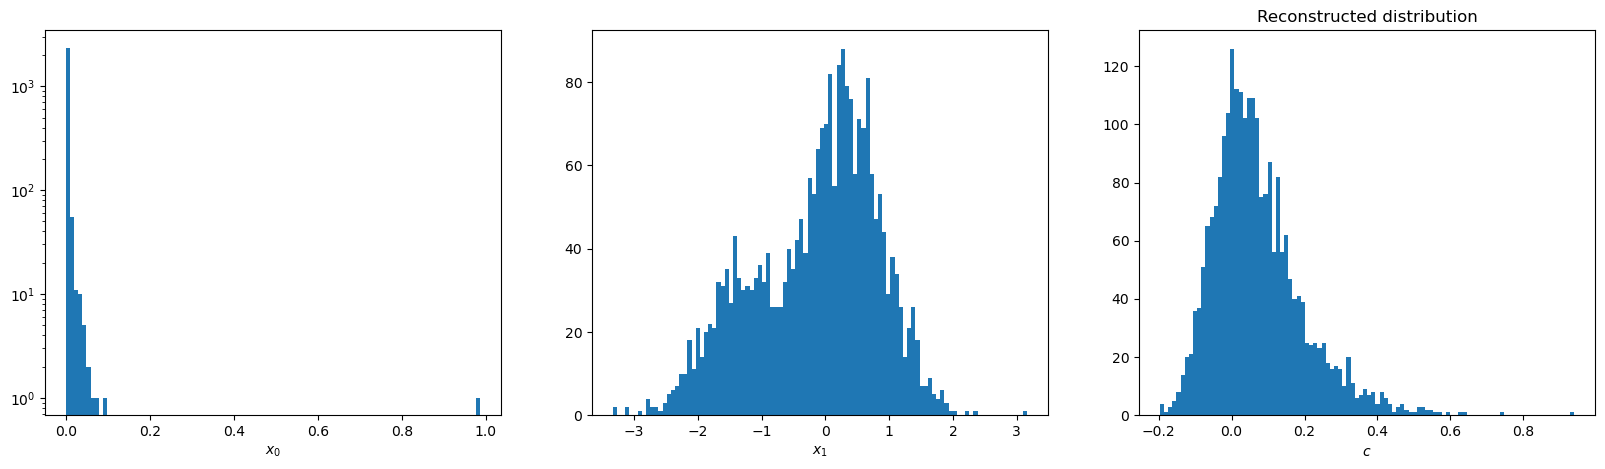

In [309]:
figure, (ax0, ax1, ac) = plt.subplots(ncols=3, figsize=(20,5))

ax0.hist(pars_trained['X0']._pars, bins=100)
ax0.set_yscale('log')
ax0.set_xlabel("$x_0$")

ax1.hist(pars_trained['X1']._pars, bins=100)
ax1.set_xlabel("$x_1$")

ac.hist(pars_trained['c']._pars, bins=100)
ac.set_xlabel("$c$")

plt.title('Reconstructed distribution')

# ZTF position in Uchuu

In [ ]:
bgs_df = load_bgs(
    columns=[
        "RA",
        "DEC",
        "Z",
        "Z_COSMO",
        "STATUS",
        "V_PEAK",
        "V_RMS",
        "R_MAG_ABS",
        "R_MAG_APP",
    ]
)

In [ ]:
ztf_sn = pandas.read_csv("data/data_ztf.csv", index_col=0)
ztf_sn

In [ ]:
snia = SNeIa_full_bgs()
data = snia.draw(size=5000, inplace=True, zmax=0.06)

In [ ]:
_ = corner_(
    ztf_sn[ztf_sn["valid"] == 1], var_names=["ra", "dec", "z", "tmax", "x0", "x1", "c"]
)

In [ ]:
%matplotlib inline

In [ ]:
survey = extract_ztf()

ztf_sn = ztf_sn[
    ztf_sn["tmax"].between(survey.date_range[0], survey.date_range[1])
].copy()
ztf_sn
nside = 128

In [ ]:
ids = healpy.ang2pix(
    theta=np.pi / 2 - ztf_sn["dec"] * np.pi / 180,
    phi=ztf_sn["ra"] * np.pi / 180,
    nside=nside,
)
map_ = np.zeros(healpy.nside2npix(nside))
for i in tqdm(ids):
    map_[i] += 1
map_ = healpy.smoothing(map_, fwhm=0.1)
map_ -= map_.min()
id_bgs = healpy.ang2pix(
    theta=np.pi / 2 - bgs_df["dec"] * np.pi / 180,
    phi=bgs_df["ra"] * np.pi / 180,
    nside=nside,
)
mask = np.zeros(healpy.nside2npix(nside), dtype=bool)
for i in tqdm(id_bgs):
    mask[i] = True
# map_[~mask]=0
map_ /= np.sum(map_)

z_nside = 64
id_bgs = healpy.ang2pix(
    theta=np.pi / 2 - bgs_df["dec"] * np.pi / 180,
    phi=bgs_df["ra"] * np.pi / 180,
    nside=z_nside,
)
bgs_pix = [[]] * healpy.nside2npix(z_nside)
for i, nb_pix in tqdm(enumerate(id_bgs), total=len(id_bgs)):
    bgs_pix[nb_pix] = bgs_pix[nb_pix] + [id_bgs.index[i]]

bgs_pix = [np.array(bgs_df.loc[ids]["z"]) for ids in bgs_pix]

In [ ]:
healpy.mollview(map_)

In [ ]:
spl = np.random.choice(np.arange(healpy.nside2npix(nside)), size=100000, p=map_)
map_sampled = np.zeros(healpy.nside2npix(nside))
for i in tqdm(spl):
    map_sampled[i] += 1
map_sampled = healpy.smoothing(map_sampled, fwhm=0.02)

healpy.mollview(map_sampled)

In [ ]:
healpy.ang2pix(z_nside, *healpy.pix2ang(nside, spl))

In [ ]:
np.where([len(l) > 0 for l in bgs_pix])[0]

In [ ]:
def rand_ztf_positions(maps, size=1, zcut=0.1):
    ztf_map, bgs_redshifts = maps
    ztf_nside = healpy.npix2nside(len(ztf_map))
    bgs_nside = healpy.npix2nside(len(bgs_nside))

    sampled_pix = np.random.choice(
        np.arange(healpy.nside2npix(nside)), size=size, p=ztf_map
    )

    bgs_sampled_pix = healpy.ang2pix(bgs_nside, *healpy.pix2ang(ztf_nside, spl))

    for angpix, zpix in zip(sampled_pix, bgs_sampled_pix):
        new_ra, new_dec = draw_from_pixel(angpix, ztf_nside)
        ra.append(new_ra)
        dec.append(new_dec)

        kde = gaussian_kde(bgs_redshifts[zpix])
        z.append(kde.resample(1)[0][0])

    return (ra, dec, z)


def draw_from_pixel(pix, nside):
    boundaries_theta, boundaries_ra = healpy.vec2ang(healpy.boundaries(nside, pix).T)
    boundaries_dec = np.pi / 2 - boundaries_theta
    boundaries_ra = boundaries_ra[
        (boundaries_dec != -np.pi / 2) & (boundaries_dec != np.pi / 2)
    ]

    min_, max_ = np.min(boundaries_ra), np.max(boundaries_ra)
    if max_ - min_ >= 2 * np.pi - np.pi / nside:
        boundaries_ra[boundaries_ra < np.pi] += 2 * np.pi
    min_, max_ = np.min(boundaries_ra), np.max(boundaries_ra)

    in_pix = False
    while not in_pix:
        draw_ra = np.random.uniform(min_, max_)
        draw_ra -= 2 * np.pi * (draw_ra > 2 * np.pi)
        draw_dec = np.arcsin(
            np.random.uniform(
                np.min(np.sin(boundaries_dec)), np.max(np.sin(boundaries_dec))
            )
        )
        in_pix = pix == healpy.ang2pix(nside, 0.5 * np.pi - draw_dec, draw_ra)

    return np.array([draw_ra, draw_dec])

In [ ]:
with open("data/bgs_redshifts_map.pkl", "wb") as fp:
    pickle.dump(bgs_pix, fp)

In [ ]:
from scipy.stats import gaussian_kde

pix = 32684
print(len(bgs_pix[pix]))
if len(bgs_pix[pix]) > 0:
    h, _, _ = plt.hist(bgs_pix[pix], density=True)
    kde = gaussian_kde(bgs_pix[pix])
    _ = plt.plot(np.linspace(0, 0.16, 1000), kde.pdf(np.linspace(0, 0.15, 1000)))
    _ = plt.vlines(bgs_pix[pix], 0, np.max(h), color="r", linestyle="--", linewidth=0.2)

In [ ]:
map_bgs = np.zeros(healpy.nside2npix(64))
for i in tqdm(id_bgs):
    map_bgs[i] += 1
map_bgs = healpy.smoothing(map_bgs, fwhm=0.1)
healpy.mollview(map_bgs)

In [ ]:
start = time.time()
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()
time.strftime("%H:%M:%S", time.gmtime(stop - start))

In [ ]:
det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index
len(detected)

In [ ]:
def detection_av_ap(dset, detected):
    n_det = []
    dset.data["detected"] = (dset.data["flux"] / dset.data["fluxerr"]) > 5
    for i in tqdm(detected):
        target = dset.targets.data.loc[i]
        obs_data = dset.data[dset.data["detected"]].loc[i]
        n_det.append(
            (
                np.sum(obs_data["time"].between(target["t0"] - 50, target["t0"])),
                np.sum(obs_data["time"].between(target["t0"], target["t0"] + 200)),
            )
        )
    return detected[~np.any(np.array(n_det) < 3, axis=1)]


id_det = detection_av_ap(dset, detected)

In [ ]:
def fit_lc(dset, id_det):
    fixed = {"z": dset.targets.data.loc[id_det]["z"]}

    guess = {
        "t0": dset.targets.data.loc[id_det]["t0"],
        "c": dset.targets.data.loc[id_det]["c"],
        "x0": dset.targets.data.loc[id_det]["x0"],
        "x1": dset.targets.data.loc[id_det]["x1"],
    }
    bounds = {
        "t0": dset.targets.data.loc[id_det]["t0"].apply(lambda x: [x - 5, x + 5]),
        "c": dset.targets.data.loc[id_det]["c"].apply(lambda x: [-0.3, 1.0]),
        "x0": dset.targets.data.loc[id_det]["x0"].apply(lambda x: [-0.1, 0.1]),
        "x1": dset.targets.data.loc[id_det]["x1"].apply(lambda x: [-4, 4]),
    }

    results, meta = dset.fit_lightcurves(
        source=sncosmo.Model("salt2"),
        index=id_det,
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
    )

    better_results = pandas.DataFrame(
        {
            **{
                col: np.array(
                    results["value"].loc[map(lambda x: (x, col), id_det[:400])]
                    - results["truth"].loc[map(lambda x: (x, col), id_det[:400])]
                )
                for col in guess.keys()
            },
            **{
                "err_"
                + col: np.array(
                    results["error"].loc[map(lambda x: (x, col), id_det[:400])]
                )
                for col in guess.keys()
            },
        }
    )
    return better_results

In [ ]:
results_ztf = fit_lc(dset, id_det[:400])

In [ ]:
fig = corner_(
    results_ztf,
    fig=plt.figure(figsize=(20, 20)),
    var_names=list(guess.keys()),
    color="tab:blue",
)

In [ ]:
snia_bgs = SNeIa_full_bgs()

In [ ]:
snia_bgs.draw(
    tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True
)
dset_bgs = skysurvey.DataSet.from_targets_and_survey(snia_bgs, survey)

In [ ]:
det = dset_bgs.get_ndetection(detlimit=7) > 10
detected_bgs = det[det].index
id_det_bgs = detection_av_ap(dset_bgs, detected_bgs)

In [ ]:
_ = plt.hist(snia_bgs.data["redshift"], bins=50, histtype="step", density=True)
_ = plt.hist(snia_bgs.data["z"], bins=50, histtype="step", density=True)
_ = plt.hist(snia.data["z"], bins=50, histtype="step", density=True)

In [ ]:
fig = corner_(
    snia_bgs.data,
    ["ra", "dec", "z"],
    fig=plt.figure(figsize=(15, 15)),
    color="tab:blue",
    bins=30,
)
_ = corner_(snia.data, ["ra", "dec", "z"], fig=fig, color="tab:red", bins=30)

In [ ]:
fig = corner_(
    snia_bgs.data.loc[id_det_bgs],
    ["ra", "dec", "z"],
    fig=plt.figure(figsize=(15, 15)),
    color="tab:blue",
    bins=30,
)
_ = corner_(
    snia.data.loc[id_det], ["ra", "dec", "z"], fig=fig, color="tab:red", bins=30
)

In [ ]:
results_bgs = fit_lc(dset_bgs, id_det_bgs[:400])

In [ ]:
fig = corner_(
    results_bgs,
    fig=plt.figure(figsize=(20, 20)),
    var_names=list(guess.keys()),
    color="tab:red",
)

_ = corner_(better_results, fig=fig, var_names=list(guess.keys()), color="tab:blue")

# EDRIS

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [6]:
from astropy.cosmology import Planck15, Planck18


In [7]:
Planck15

FlatLambdaCDM(name='Planck15', H0=<Quantity 67.74 km / (Mpc s)>, Om0=0.3075, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.0486)

In [8]:
Planck18

FlatLambdaCDM(name='Planck18', H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.30966, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.04897)

### Run

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)

In [ ]:
index = data[data["converged"]].index

In [ ]:
# %lprun -f sncosmo_to_edris
exp, cov, obs = sncosmo_to_edris(res_sn, data, index, n_bins=6)

In [ ]:
_ = corner_(
    data[data["used_edris"]], var_names=["x0", "x1", "c", "t0", "ra", "dec", "z"]
)

In [ ]:
plt.hist(exp["z"], bins=exp["z_bins"], log=True)
plt.xlabel("$z$")
plt.title("Redshift bins")

In [ ]:
plt.scatter(exp["z"], obs.mag, s=1)
plt.plot(np.linspace(5e-3, 0.06), mag_Planck18(np.linspace(5e-3, 0.06)), ':k')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.imshow(cov.C_mm, norm="log")
ax2.imshow(cov.C_mx, norm="log")
ax3.imshow(cov.C_xx, norm="log")

In [ ]:
res, hess, loss, iter_params = run_edris(obs, cov, exp, verbose=True)

In [ ]:
cov_res = get_cov_from_hess(hess)

sigma_inv = jnp.diag(1 / jnp.sqrt(jnp.diag(cov_res)))
corr = jnp.matmul(sigma_inv, jnp.matmul(cov_res, sigma_inv))

n_var = len(hess["coef"]["coef"])
n_bins = len(hess["mu_bins"]["mu_bins"])
n = hess["variables"]["variables"].shape[1]

In [ ]:
from matplotlib import colors

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
im1 = ax1.imshow(corr, norm=colors.Normalize(vmin=-1.0, vmax=1.0))
ax1.set_title(f"Correlation (2 coeff, {n_bins} bins, {n} $x_1$, {n} $c$)")
ax1.hlines(
    [n_var + n_bins - 0.5, n + n_var + n_bins - 0.5],
    xmin=0,
    xmax=n_var * n + n_var + n_bins - 0.5,
    linestyle="--",
    linewidth=1,
    color="r",
)
ax1.vlines(
    [n_var + n_bins - 0.5, n + n_var + n_bins - 0.5],
    ymin=0,
    ymax=n_var * n + n_var + n_bins - 0.5,
    linestyle="--",
    linewidth=1,
    color="r",
)
cb = ax2.figure.colorbar(im1, ax=ax1)

im2 = ax2.imshow(
    corr[: n_bins + 2, : n_bins + 2], norm=colors.Normalize(vmin=-1.0, vmax=1.0)
)
ax2.set_title("Correlation of coefs and mu_bins")
ax2.figure.colorbar(im2, ax=ax2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
im1 = ax1.imshow(-jnp.sign(cov_res) * jnp.log(jnp.abs(cov_res)))
ax1.set_title(f"Covariance ({n_var} coeff, {n_bins} bins, {n} $x_1$, {n} $c$)")
ax1.hlines(
    [n_var + n_bins - 0.5, n + n_var + n_bins - 0.5],
    xmin=0,
    xmax=n_var * n + n_var + n_bins - 0.5,
    linestyle="--",
    linewidth=1,
    color="r",
)
ax1.vlines(
    [n_var + n_bins - 0.5, n + n_var + n_bins - 0.5],
    ymin=0,
    ymax=n_var * n + n_var + n_bins - 0.5,
    linestyle="--",
    linewidth=1,
    color="r",
)

im2 = ax2.imshow(
    (-jnp.sign(cov_res) * jnp.log(jnp.abs(cov_res)))[: n_bins + 2, : n_bins + 2]
)
ax2.set_title("Covariance of coefs and mu_bins")

ax2.figure.colorbar(im1, ax=ax1)
ax2.figure.colorbar(im2, ax=ax2)
# plt.savefig(f'../figures/edris_pets_cov.png')

In [ ]:
std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

fig, (ax1, ax2) = plt.subplots(
    nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
)

ax1.errorbar(
    exp["z_bins"],
    res["mu_bins"],
    yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
    color="tab:blue",
    label="edris",
)
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    mag_Planck18(np.linspace(5e-3, 0.06, 1000)),
    color="tab:green",
    linestyle=":",
    label="Planck18",
)

ax1.scatter(
    exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
)
ax1.legend()
ax1.set_ylabel(r"$\mu$")
fig.suptitle(r"Modèle fitté par Edris")

ax2.errorbar(
    exp["z_bins"],
    res["mu_bins"] - mag_Planck18(exp["z_bins"]),
    yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
    color="tab:blue",
)
ax2.scatter(exp["z"], std_mag - mag_Planck18(exp["z"]), color="k", s=0.5, alpha=0.3)
lims = ax2.get_xlim()
ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
ax2.set_xlim(*lims)
ax2.set_ylabel(r"$\Delta\mu$")
ax2.set_xlabel(r"$z$")
plt.savefig("../figures/Abacus_edris_fit.png")

In [ ]:
with open("outdir/SN_Abacus_edris_res.pkl", "wb") as f:
    pickle.dump(exp, f)
    pickle.dump(obs, f)
    pickle.dump(cov, f)
    pickle.dump(res, f)
    pickle.dump(cov_res, f)
    pickle.dump(iter_params, f)

In [ ]:
with open("outdir/SN_Abacus.pkl", "wb") as f:
    pickle.dump(lc, f)
    pickle.dump(data, f)
    pickle.dump(res_sn, f)
    pickle.dump(meta, f)

In [ ]:
better_results = pandas.DataFrame(
    {
        **{
            col: np.array(res_sn["value"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
        **{
            "err_" + col: np.array(res_sn["error"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
        **{
            "delta_"
            + col: np.array(res_sn["value"].loc[map(lambda x: (x, col), index)])
            - np.array(res_sn["truth"].loc[map(lambda x: (x, col), index)])
            for col in ["t0", "c", "x0", "x1"]
        },
    },
    index=index,
)

### Smooth cosmo

In [ ]:
with open("outdir/SN_Abacus.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)

index = data[data["converged"]].index

# %lprun -f sncosmo_to_edris
exp, cov, obs = sncosmo_to_edris(res_sn, data, index, n_bins=6)

In [ ]:
exp['z'] = jnp.array(data[data["used_edris"]]["z_cosmo"])

In [ ]:
exp['z_bins'] = jnp.logspace(exp['z'].min()-1e-4, 0.06, 6)

In [ ]:
from astropy.cosmology import Planck18

In [167]:
from edris.tools import linear_interpolation
from astropy.constants import c

def integrand(Omega_m, Omega_r, Omega_l, u):
    return 1 / jnp.sqrt(Omega_m + Omega_r * u ** (-2) + Omega_l * u**6)


def dist(
    z,
    Omega_m=Planck18.Om0,
    Omega_r=5e-5,
    Omega_l=Planck18.Ode0,
    H0=Planck18.H0.value,
    nstep=10000,
    **kwargs
):
    dh = c.value * 1e-3 / H0
    u = 1 / jnp.sqrt(1 + z)
    umin = 0.02
    step = (1 - umin) / nstep
    _u = jnp.arange(umin + 0.5 * step, 1, step)
    csum = jnp.cumsum(integrand(Omega_m, Omega_r, Omega_l, _u[-1::-1]))[-1::-1]
    R = linear_interpolation(u, csum, _u - 0.5 * step) * 2 * step * dh
    return R

In [168]:
def cosmo(params, exp):
    return 5.0 * jnp.log10(abs(exp["z"] + 1.0) * dist(exp["z"], **params)) + 25 - 19.3

In [169]:
x0 = {
    "Omega_m": jnp.array([Planck18.Om0]),
    # "Omega_r": jnp.array([5e-5]),
    # "Omega_l": jnp.array([Planck18.Ode0]),
    # "H0": jnp.array([Planck18.H0.value]),
    "coef": jnp.array([-0.14, 3.15]),
    "variables": jnp.array(obs.variables.reshape((2, -1))),
}

In [170]:
x0

{'Omega_m': Array([0.30966], dtype=float64),
 'coef': Array([-0.14,  3.15], dtype=float64),
 'variables': Array([[ 0.27814587,  0.1458866 ,  0.86229525, ..., -0.04912354,
          1.25459252,  0.89985897],
        [-0.00306796,  0.03838602,  0.01896368, ..., -0.00672801,
         -0.03121977,  0.02729959]], dtype=float64)}

In [172]:
L = lambda x: restrict(
    likelihood,
    {
        "sigma_int": .1,
    },
)(x, exp, cov, obs, cosmo=cosmo, truncated=False, restricted=False)
params = dict(niter=1000, lmbda=1e4, tol=1e-2, max_iter_tncg=None, verbose=True)


In [ ]:
# plt.plot([param["H0"]-x0["H0"] for param in iter_params], label='$H_0$')
plt.plot([param["coef"]-x0["coef"] for param in iter_params], label=['$\\alpha$', '$\\beta$'])
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Biais')
plt.axhline(0, linestyle=':', color='k')
plt.show()

In [ ]:
res

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(loss)
plt.title("Loss")
plt.xlabel('Iteration')
plt.xscale('log')

In [ ]:
std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

fig, (ax1, ax2) = plt.subplots(
    nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
)

ax1.plot(
    jnp.linspace(5e-3, 0.06, 1000),
    cosmo(res, {"z": jnp.linspace(5e-3, 0.06, 1000)}),
    color="tab:blue",
    label="edris",
)
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    mag_Planck18(np.linspace(5e-3, 0.06, 1000)),
    color="tab:green",
    linestyle=":",
    label="Planck18",
)

ax1.scatter(
    exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
)
ax1.legend()
ax1.set_ylabel(r"$\mu$")
fig.suptitle(r"Modèle fitté par Edris pour Abacus")

ax2.plot(
    jnp.linspace(5e-3, 0.06, 1000),
    cosmo(res, {"z": jnp.linspace(5e-3, 0.06, 1000)}) - mag_Planck18(jnp.linspace(5e-3, 0.06, 1000)),
    color="tab:blue",
)
ax2.scatter(exp["z"], std_mag - mag_Planck18(exp["z"]), color="k", s=0.5, alpha=0.3)
lims = ax2.get_xlim()
ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
ax2.set_xlim(*lims)
ax2.set_ylabel(r"$\Delta\mu$")
ax2.set_xlabel(r"$z$")
# plt.savefig("../figures/Abacus_edris_fit.png")

In [ ]:
data[data['used_edris']].hist("z", bins=exp['z_bins'], log=True)

In [ ]:
hess = jax.hessian(L)(res)

n_var = len(hess["coef"]["coef"])
n = hess["variables"]["variables"].shape[1]

row1 = jnp.hstack(
    (
        hess["coef"]["coef"],
        hess["coef"]["H0"].reshape(n_var, 1),
        hess["coef"]["variables"].reshape(n_var, n * n_var),
    )
)
row2 = jnp.hstack(
    (
        hess["H0"]["coef"].reshape(1, n_var),
        hess["H0"]["H0"].reshape(1, 1),
        hess["H0"]["variables"].reshape(1, n * n_var),
    )
)
row3 = jnp.hstack(
    (
        hess["variables"]["coef"].reshape(n * n_var, n_var),
        hess["variables"]["H0"].reshape(n * n_var, 1),
        hess["variables"]["variables"].reshape(n * n_var, n * n_var),
    )
)
flatten_hessian = jnp.vstack((row1, row2, row3))
cov_res = jnp.linalg.inv(0.5 * flatten_hessian)

In [ ]:
jnp.diag(cov_res)[:3]

### Likelihood profile

In [173]:
L = lambda x: likelihood(x, exp, cov_sel, obs, cosmo=cosmo, truncated=False, restricted=False)

interest : sigma_int, alpha, beta, Omega_m, Omega_r, Omega_l, H0

In [174]:
x0 = {
    "Omega_m": jnp.array([Planck18.Om0]),
    "Omega_r": jnp.array([5e-5]),
    "Omega_l": jnp.array([Planck18.Ode0]),
    "H0": jnp.array([Planck18.H0.value]),
    "sigma_int": jnp.array([0.1]),
    "coef": jnp.array([-0.14, 3.15]),
    "variables": jnp.array(obs.variables.reshape((2, -1))),
}
x0

{'Omega_m': Array([0.30966], dtype=float64),
 'Omega_r': Array([5.e-05], dtype=float64),
 'Omega_l': Array([0.68884631], dtype=float64),
 'H0': Array([67.66], dtype=float64),
 'sigma_int': Array([0.1], dtype=float64),
 'coef': Array([-0.14,  3.15], dtype=float64),
 'variables': Array([[ 0.27814587,  0.1458866 ,  0.86229525, ..., -0.04912354,
          1.25459252,  0.89985897],
        [-0.00306796,  0.03838602,  0.01896368, ..., -0.00672801,
         -0.03121977,  0.02729959]], dtype=float64)}

In [196]:
def profile(Omega_m=Planck18.Om0, Omega_r=5e-5, Omega_l=Planck18.Ode0, H0=Planck18.H0.value, sigma_int=0.1, alpha=-0.14, beta=3.15):
    x_ = x0.copy()
    x_.update(**{
            "Omega_m": jnp.array([Omega_m]),
            "Omega_r": jnp.array([Omega_r]),
            "Omega_l": jnp.array([Omega_l]),
            "H0": jnp.array([H0]),
            "sigma_int": jnp.array([sigma_int]),
            "coef": jnp.array([alpha, beta]),
            "variables": jnp.array(obs.variables.reshape((2, -1))),}
             )
    return L(x_)

In [197]:
profile_vect = jax.vmap(profile)

In [267]:
lims = dict(sigma_int=(0.05, 0.4),
            alpha=(-0.3,0.05),
            beta=(3.0,3.5),
            Omega_m=(0.1,0.4),
            Omega_l=(0.5, 0.8),
            H0=(60,70))

In [268]:
grids={key:jnp.linspace(*lims[key], 100) for key in lims.keys()}

In [269]:
latex_labels = ["$\\sigma_{int}$", "$\\alpha$", "$\\beta$", "$\\Omega_m$", "$\\Omega_l$", "$H_0$"]

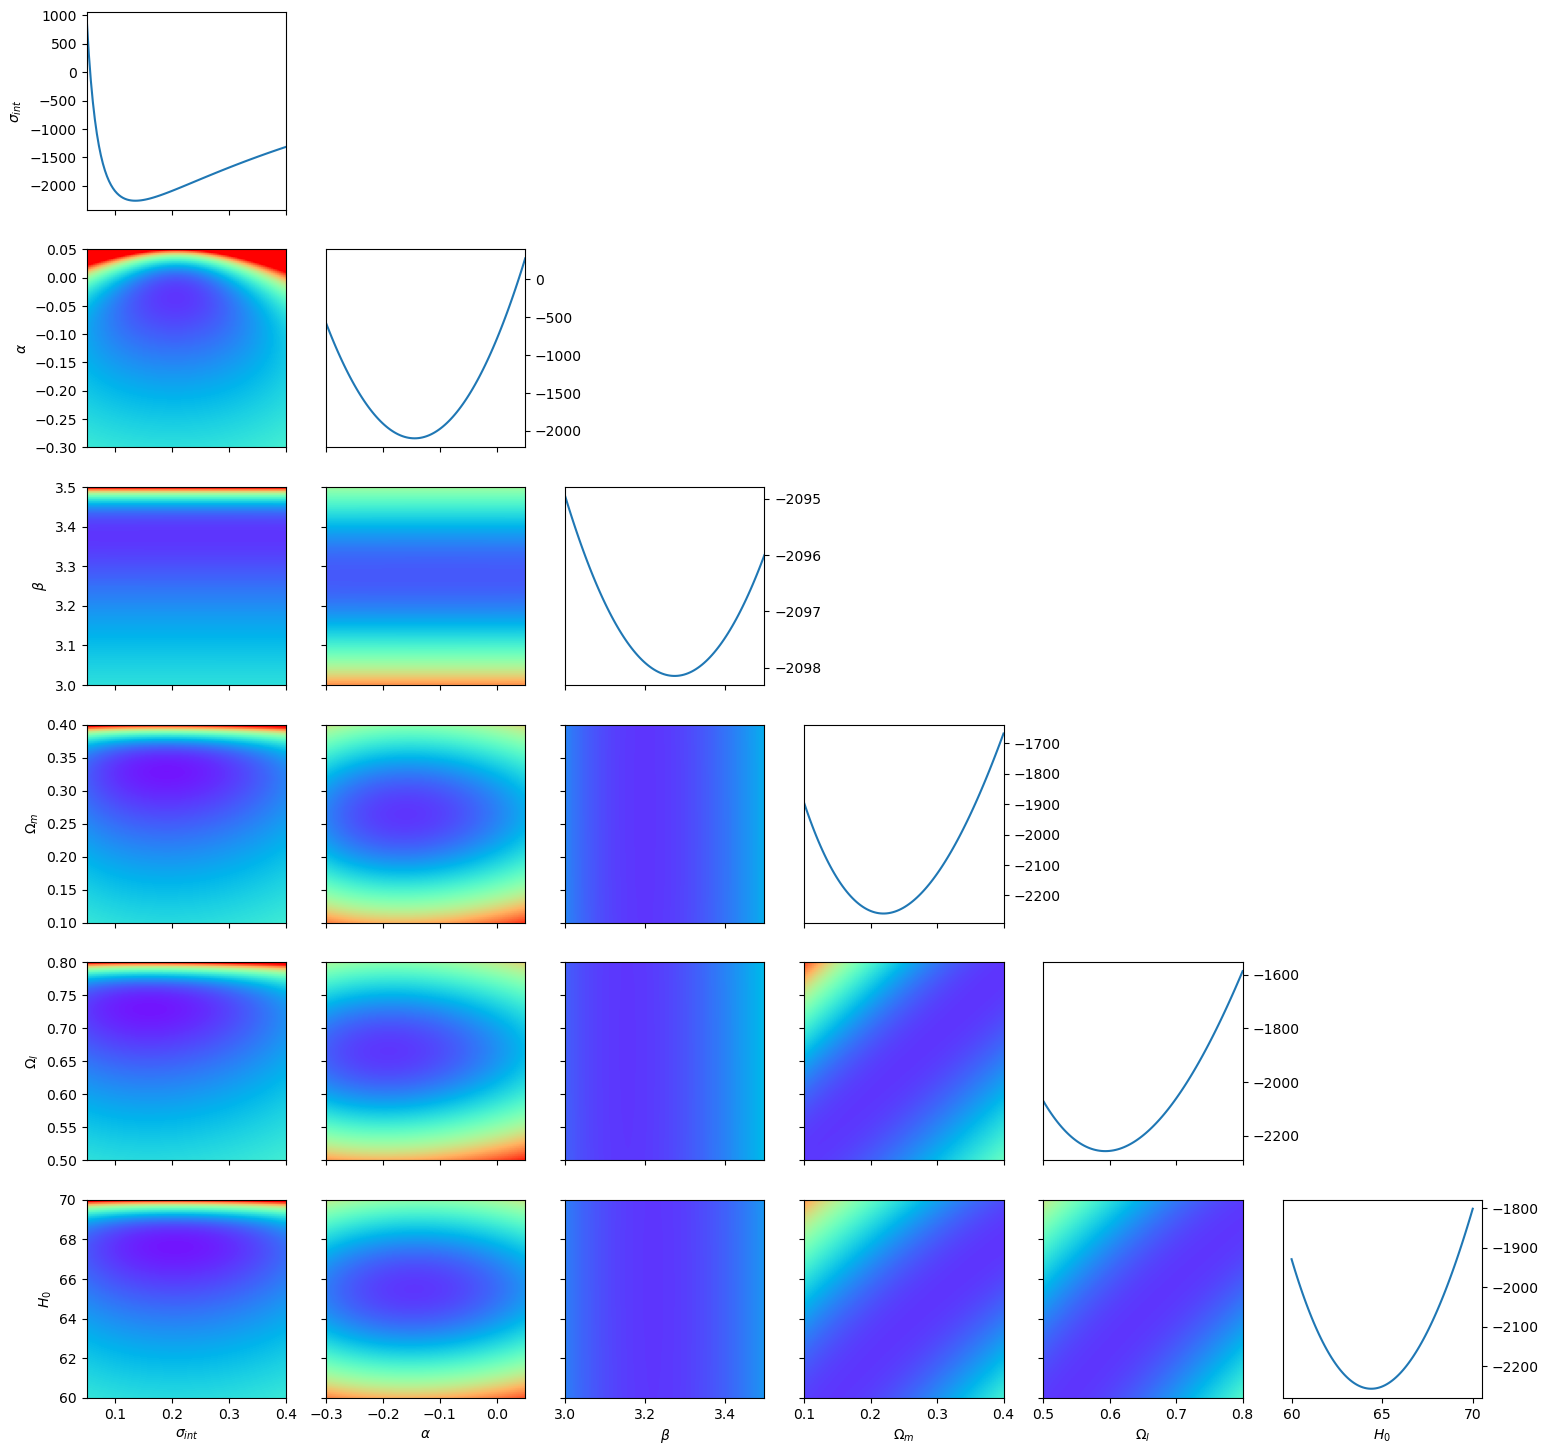

In [271]:
import matplotlib

fig, axs = plt.subplots(nrows=len(lims), ncols=len(lims), sharex="col", figsize=(3*len(lims),3*len(lims)), dpi=100)

for i, key in enumerate(lims.keys()):
    
    axs[i,i].plot(grids[key], profile_vect(**{key:grids[key]}))
    axs[i,0].set_ylabel(latex_labels[i])
    axs[len(lims.keys())-1,i].set_xlabel(latex_labels[i])

    for j, key_2 in enumerate(lims.keys()):
        
        if j > i:
            axs[i,j].remove()
            continue
        elif j==i:
            if j!=0:
                axs[i,i].yaxis.tick_right()
            continue
        if j > 0:
            axs[i,j].set_yticklabels([])
            axs[i,j].set_yticklabels([], minor=True)
        
        mesh = jnp.meshgrid(grids[key], grids[key_2])
        axs[i,j].imshow(profile_vect(**{key:mesh[0].reshape(-1), key_2:mesh[1].reshape(-1)}).reshape(len(grids[key]), len(grids[key_2])),
                        vmin=-2500, vmax=1000,
                        extent=(*lims[key_2], *lims[key]),
                        aspect="auto",
                        cmap='rainbow')

In [237]:
plt.close()

### NACL

In [56]:
with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)

In [10]:
from nacl.train import TrainSALT2Like

2024-06-24 07:30:14,967 INFO sparse_dot_mkl found. Building hessian should be faster.
2024-06-24 07:30:14,971 INFO sparse_dot_mkl found. Building hessian should be faster.
2024-06-24 07:30:15,000 INFO sparse_dot_mkl found. Building hessian should be faster.


In [11]:
trainer = TrainSALT2Like.load('outdir/nacl_Uchuu.pkl')

In [12]:
pars_trained = trainer.log[-1].pars
v_trained = trainer.log[-1].v

In [13]:
with np.load('/pscratch/sd/a/agillesl/Documents/Projet_LPNHE/nacl_cov.npz') as dat:
    cov_matrix=dat['arr_0'][:4*len(trainer.tds.sn_data),:4*len(trainer.tds.sn_data)]

In [14]:
df = pandas.DataFrame({par:pars_trained[par]._pars for par in ["X0","X1","c","tmax"]})

In [15]:
pars_trained

X0: array([0.00064868, 0.00220169, 0.00412784, ..., 0.00278399, 0.00137466,
       0.00674562])
X1: array([0.06002732, 0.27814587, 0.46132784, ..., 0.88036128, 1.25459252,
       0.89985897])
c: array([ 0.12828487, -0.00306796, -0.07326415, ..., -0.05044331,
       -0.03121977,  0.02729959])
tmax: array([58580.81373945, 58496.39310408, 59145.33070652, ...,
       58513.99479468, 58533.60422898, 59169.5738639 ])
M0: array([-0.15070802,  0.07229653, -0.06075972, ...,  0.00956892,
        0.02014822,  0.02102974])
M1: array([ 0.46589648, -0.22507922,  0.19000084, ..., -0.01509885,
        0.00233429, -0.01092853])
CL: array([ 0.05135508, -0.310631  ,  0.64314887, -0.72137735])
SpectrumRecalibration: array([ 0.24674862, -0.32767513,  0.1949968 , ...,  0.0634528 ,
        0.15029969, -4.97645935])
gamma_snake: array([ 1.00000000e-02,  1.00000000e-02,  1.00000000e-02,  8.79001265e+00,
        7.87878228e+01,  5.12977392e+01,  6.56084051e+01,  1.96989743e+01,
        2.80319555e+01,  1.921699

In [16]:
n = len(df)

In [17]:
from scipy.sparse import csc_matrix

In [18]:
alpha = csc_matrix(jnp.diag(jnp.hstack([(-2.5 / (np.log(10) * pars_trained['X0']._pars)), jnp.ones(2*n)])))

In [19]:
cov_mb = (alpha @ csc_matrix(cov_matrix[:3*n,:3*n]) @ alpha).toarray()

In [20]:
M0 = 10.508548

In [21]:
df['Mb'] = -2.5*np.log10(df['X0']) + M0

In [22]:
df['cov_X0'] = jnp.diag(cov_matrix[:n,:n])
df['cov_Mb'] = jnp.diag(cov_mb)[:n]
df['cov_X1'] = jnp.diag(cov_mb)[n:2*n]
df['cov_c'] = jnp.diag(cov_mb)[2*n:3*n]

2024-06-24 07:31:12,150 WARNING Pandas support in corner is deprecated; use ArviZ directly


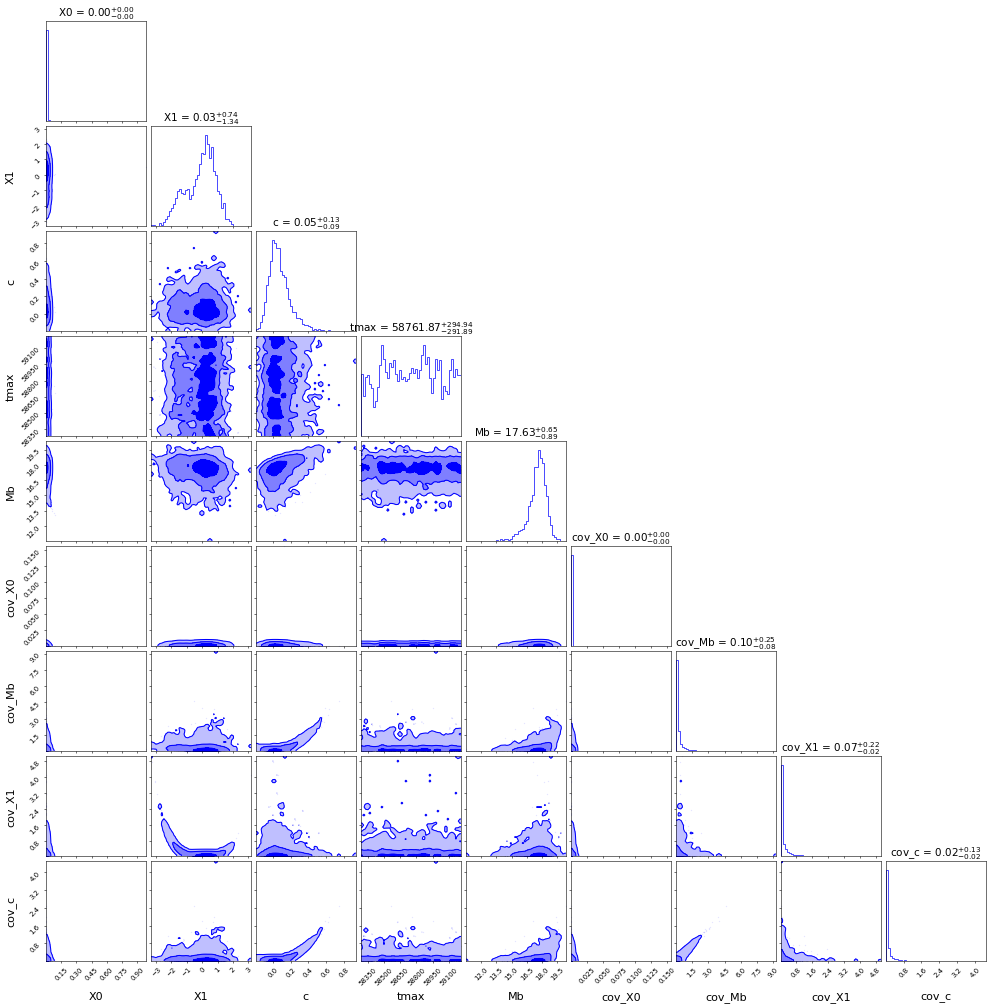

In [23]:
_= corner_(df)

In [24]:
from edris.models import FullCovariance

In [25]:
cov = FullCovariance(cov_mb[:n,:n], cov_mb[n:,n:], cov_mb[:n,n:])

Text(0.5, 0, '$\\sigma_c$')

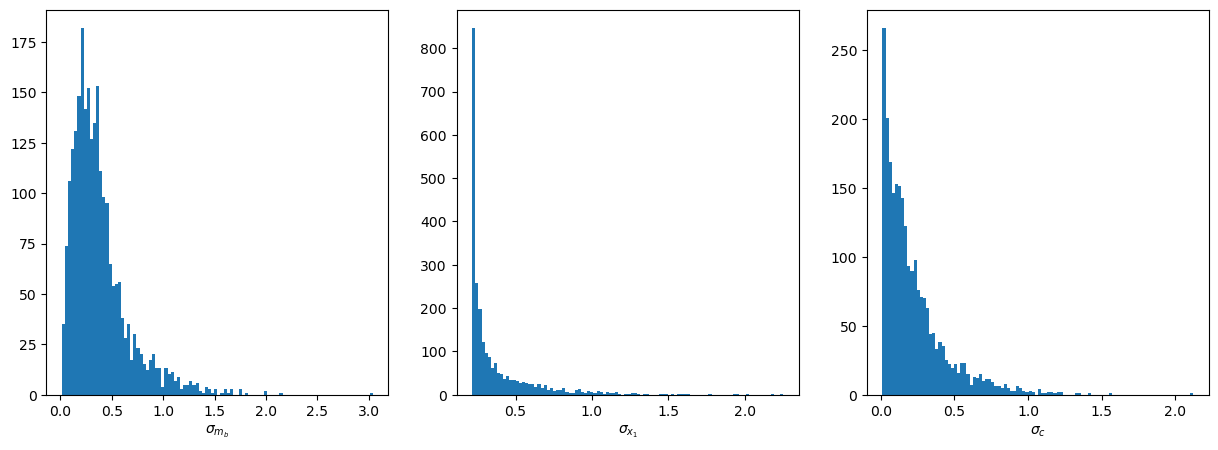

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
ax1.hist(np.sqrt(df['cov_Mb']), bins=100)
ax1.set_xlabel('$\\sigma_{m_b}$')
ax2.hist(np.sqrt(df['cov_X1']), bins=100)
ax2.set_xlabel('$\\sigma_{x_1}$')
ax3.hist(np.sqrt(df['cov_c']), bins=100)
ax3.set_xlabel('$\\sigma_c$')

In [27]:
filt = (jnp.abs(pars_trained['c']._pars) < 0.3) & \
        (jnp.sqrt(df['cov_c'].to_numpy()) < 0.1) & \
        (jnp.abs(pars_trained['X1']._pars) + df['cov_X1'].to_numpy() < 5) & \
        (df['cov_X1'].to_numpy() < 1)

In [28]:
sum(filt)

Array(788, dtype=int64, weak_type=True)

In [29]:
df['used_edris']=filt

2024-06-24 07:33:09,209 WARNING Pandas support in corner is deprecated; use ArviZ directly


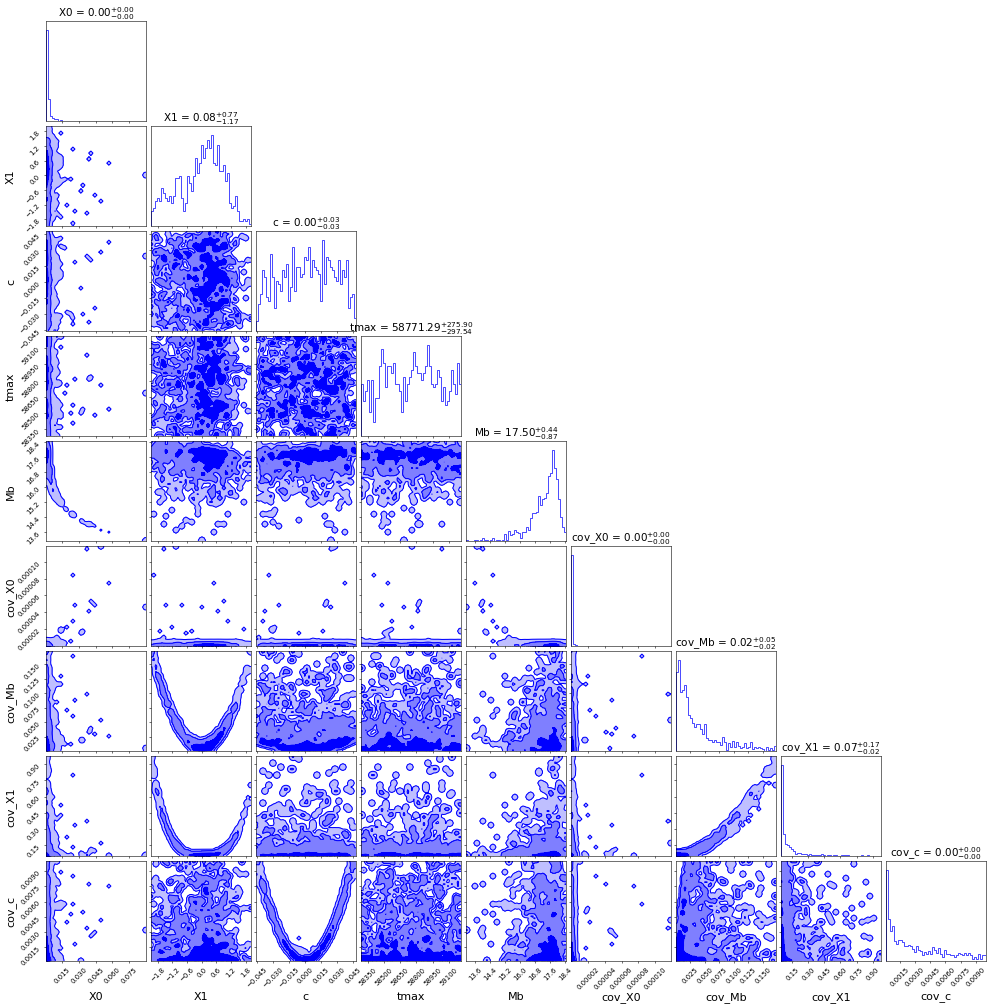

In [30]:
_= corner_(df[df['used_edris']], var_names=["~used_edris"])

In [31]:
cov_sel = cov.select(df['used_edris'].to_numpy())

In [32]:
n = sum(df['used_edris'])

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(20, 5))
ax1.hist(jnp.diag(cov_sel.C_mm), bins=100)
ax1.set_xlabel('$\\sigma_{m_b}$')
ax2.hist(jnp.diag(cov_sel.C_xx[:n,:n]), bins=100)
ax2.set_xlabel('$\\sigma_{x_1}$')
ax3.hist(jnp.diag(cov_sel.C_xx[n:,n:]), bins=100)
ax3.set_xlabel('$\\sigma_c$')

# ax4.hist(cov_sel.C_mx[:,:n].reshape(-1), bins=100)
# ax4.set_xlabel('$cov_{m_b, x_1}$')
# ax5.hist(cov_sel.C_mx[:,n:].reshape(-1), bins=100)
# ax5.set_xlabel('$cov_{m_b, c}$')
# ax6.hist(cov_sel.C_xx[:n,n:].reshape(-1), bins=100)
# ax6.set_xlabel('$cov_{c, x_1}$')

In [43]:
cor_mm = jnp.diag(1/jnp.sqrt(jnp.diag(cov_sel.C_mm))) @ cov_sel.C_mm @ jnp.diag(1/jnp.sqrt(jnp.diag(cov_sel.C_mm)))
cor_mx = jnp.diag(1/jnp.sqrt(jnp.diag(cov_sel.C_mm))) @ cov_sel.C_mx @ jnp.diag(1/jnp.sqrt(jnp.diag(cov_sel.C_xx)))
cor_xx = jnp.diag(1/jnp.sqrt(jnp.diag(cov_sel.C_xx))) @ cov_sel.C_xx @ jnp.diag(1/jnp.sqrt(jnp.diag(cov_sel.C_xx)))

In [ ]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
ax1.hist(cor_mm.reshape(-1), bins=100)
ax1.set_xlabel('$corr_{m_b}$')
ax2.hist(cor_xx[:n,:n].copy().reshape(-1), bins=100)
ax2.set_xlabel('$corr_{x_1}$')
ax3.hist(cor_xx[n:,n:].copy().reshape(-1), bins=100)
ax3.set_xlabel('$corr_c$')

ax4.hist(cor_mx[:n,:n].copy().reshape(-1), bins=100)
ax4.set_xlabel('$corr_{m_b, x_1}$')
ax5.hist(cor_mx[:n,n:].copy().reshape(-1), bins=100)
ax5.set_xlabel('$corr_{m_b, c}$')
ax6.hist(cor_xx[:n,n:].copy().reshape(-1), bins=100)
ax6.set_xlabel('$corr_{c, x_1}$')

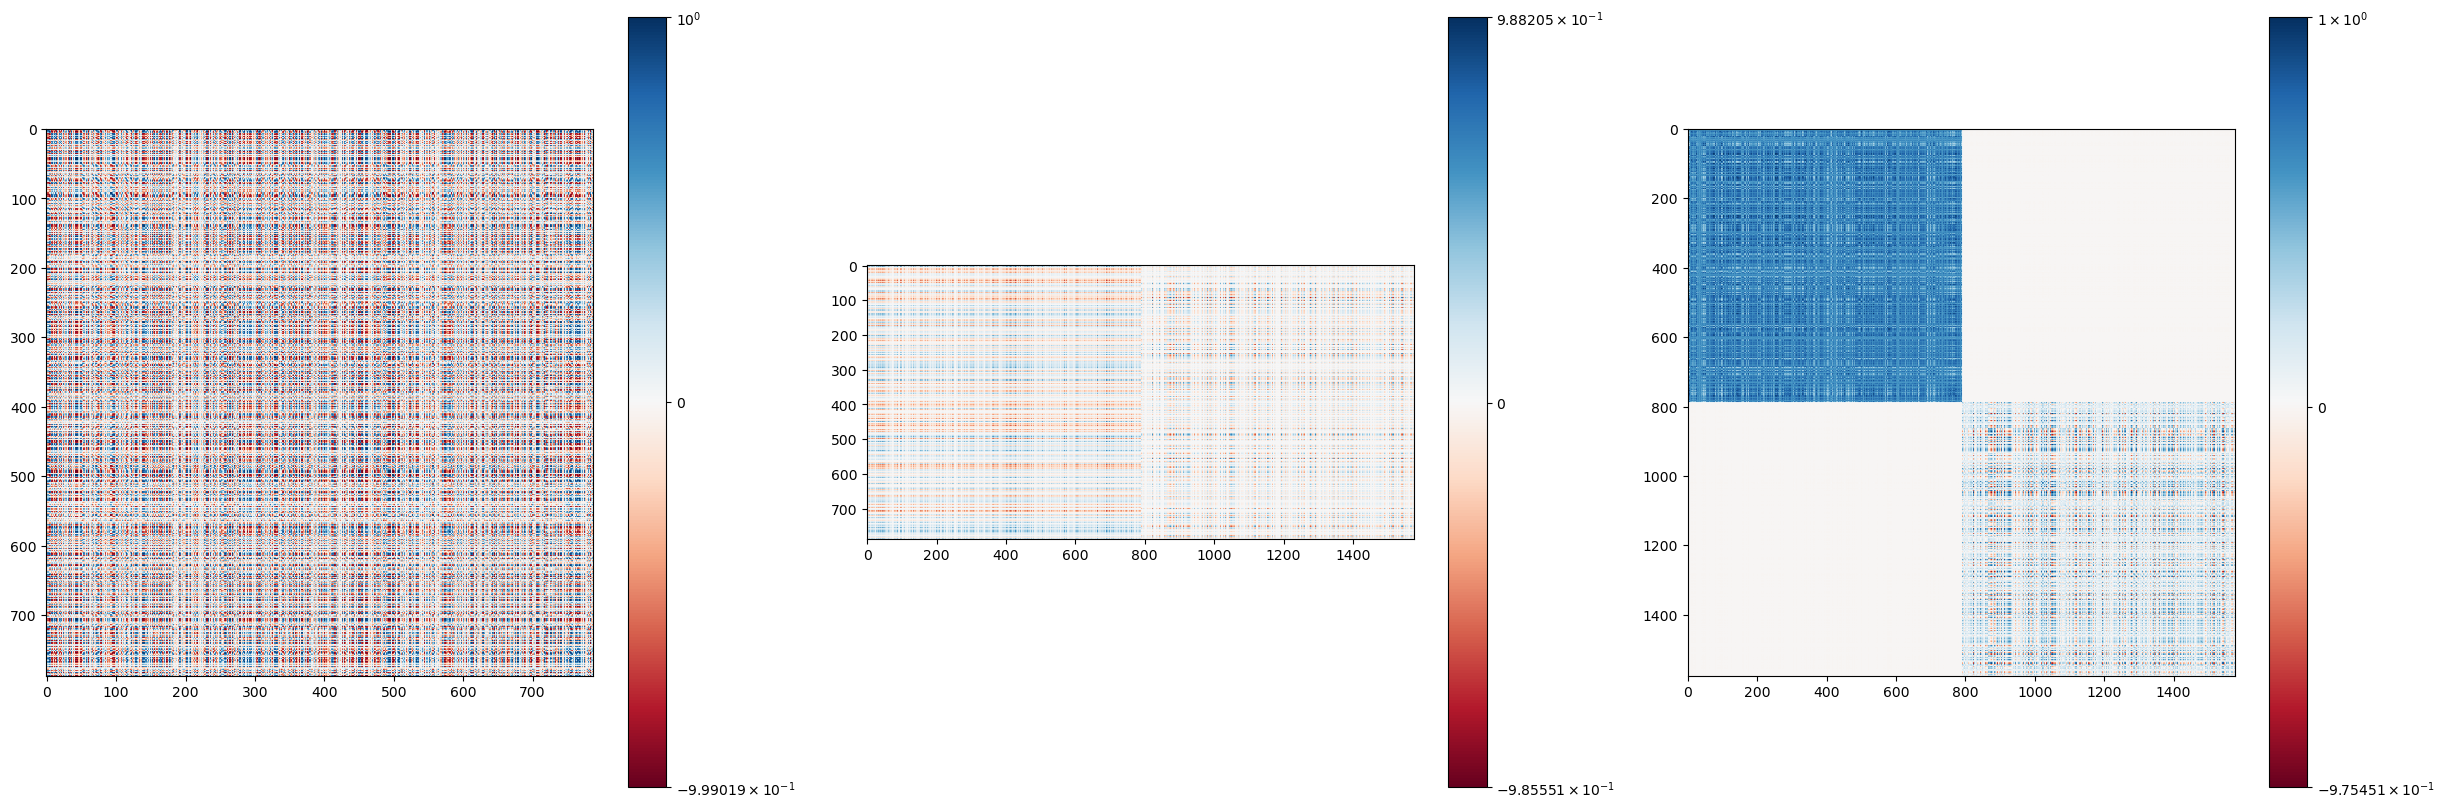

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 10))
im1 = ax1.imshow(cor_mm, norm="symlog", cmap='RdBu')
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(cor_mx, norm="symlog", cmap='RdBu')
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(cor_xx, norm="symlog", cmap='RdBu')
plt.colorbar(im3, ax=ax3)

In [45]:
cov_spl_mm = jnp.diag(jnp.diag(cov_sel.C_mm))
cov_spl_mx = jnp.hstack([jnp.diag(jnp.diag(cov_sel.C_mx[:,:n])), jnp.diag(jnp.diag(cov_sel.C_mx[:,n:]))])
cov_spl_xx = jnp.vstack([jnp.hstack([jnp.diag(jnp.diag(cov_sel.C_xx[:n,:n])), jnp.diag(jnp.diag(cov_sel.C_xx[:n,n:]))]),
                     jnp.hstack([jnp.diag(jnp.diag(cov_sel.C_xx[n:,:n])), jnp.diag(jnp.diag(cov_sel.C_xx[n:,n:]))])])

In [46]:
cov_spl = FullCovariance(cov_mm=cov_spl_mm, cov_mx=cov_spl_mx, cov_xx=cov_spl_xx)

In [47]:
exp={'z':jnp.array(trainer.tds.sn_data.z[df['used_edris']])}

In [48]:
len(exp['z']), sum(filt)

(788, Array(788, dtype=int64, weak_type=True))

In [49]:
from edris.tools import log_bins
exp['z_bins'] = log_bins(exp['z'].min() - 1e-4, 0.06, 5)

In [50]:
from edris.models import Obs

In [51]:
obs=Obs(jnp.array(-2.5 * np.log10(pars_trained["X0"]._pars[df['used_edris']]) + M0),
        jnp.hstack([pars_trained["X1"]._pars[df['used_edris']], 
                    pars_trained["c"]._pars[df['used_edris']]]))

In [52]:
from astropy.cosmology import Planck15
def mag_Planck15(z):
    return jnp.array(Planck15.distmod(np.array(z))) - 19.3 

In [57]:
data['used_edris'] = False

In [58]:
data.loc[data[data['good']].index, 'used_edris'] = np.array(df['used_edris'])

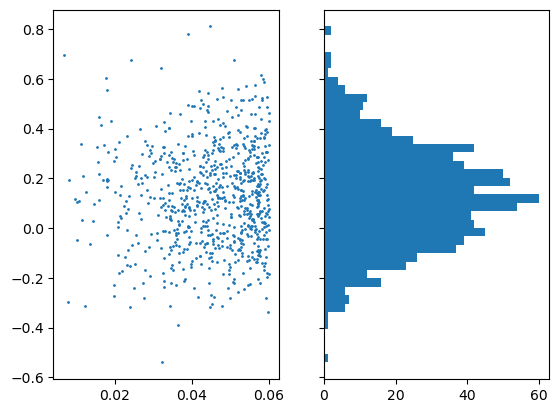

In [59]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey='row')
ax1.scatter(exp['z'], obs.mag - mag_Planck15(exp['z']), s=1)
_=ax2.hist(obs.mag - mag_Planck15(exp['z']), orientation='horizontal', bins=40)

In [61]:
from edris.tools import linear_interpolation
from astropy.constants import c

def integrand(Omega_m, Omega_r, Omega_l, u):
    return 1 / jnp.sqrt(Omega_m + Omega_r * u ** (-2) + Omega_l * u**6)


def dist(
    z,
    Omega_m=Planck15.Om0,
    Omega_r=5e-5,
    Omega_l=Planck15.Ode0,
    H0=Planck15.H0.value,
    nstep=10000,
    **kwargs
):
    dh = c.value * 1e-3 / H0
    u = 1 / jnp.sqrt(1 + z)
    umin = 0.02
    step = (1 - umin) / nstep
    _u = jnp.arange(umin + 0.5 * step, 1, step)
    csum = jnp.cumsum(integrand(Omega_m, Omega_r, Omega_l, _u[-1::-1]))[-1::-1]
    R = linear_interpolation(u, csum, _u - 0.5 * step) * 2 * step * dh
    return R

In [62]:
def cosmo(params, exp):
    return 5.0 * jnp.log10(abs(exp["z"] + 1.0) * dist(exp["z"], **params)) + 25 - 19.3

In [313]:
x0 = {
    # "mu_bins": jnp.array(mag_Planck15(exp['z_bins'])),
    "Omega_m": jnp.array([Planck15.Om0]),
    # "Omega_r": jnp.array([5e-5]),
    # "Omega_l": jnp.array([Planck15.Ode0]),
    # "H0": jnp.array([Planck15.H0.value]),
    "coef": jnp.array([-0.14, 3.15]),
    "variables": jnp.array(obs.variables.reshape((2, -1))),
    # "sigma_int":jnp.array([0.1]),
}

In [65]:
x0

{'Omega_m': Array([0.3075], dtype=float64),
 'coef': Array([-0.14,  3.15], dtype=float64),
 'variables': Array([[ 0.27814587,  0.1458866 ,  0.86229525, ..., -0.04912354,
          1.25459252,  0.89985897],
        [-0.00306796,  0.03838602,  0.01896368, ..., -0.00672801,
         -0.03121977,  0.02729959]], dtype=float64)}

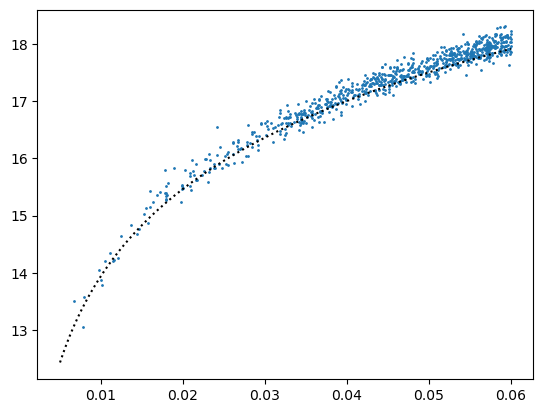

In [66]:
plt.scatter(exp['z'], obs.mag-jnp.matmul(x0['coef'], obs.variables.reshape((2, -1))), s=1)
plt.plot(jnp.linspace(5e-3, 0.06, 1000), mag_Planck15(jnp.linspace(5e-3, 0.06, 1000)), ':k')

In [69]:
L = lambda x: restrict(likelihood,{"sigma_int": .1,},)(x, exp, cov_spl, obs, cosmo=cosmo, truncated=False, restricted=False)
# L = lambda x: likelihood(x, exp, cov_spl, obs, cosmo=binned_cosmo, truncated=False, restricted=False)
params = dict(niter=1000, lmbda=1e4, tol=1e-2, max_iter_tncg=None, verbose=True)

In [ ]:
res, loss, lmbda, iter_params = tncg(L, x0, **params)

In [ ]:
res

In [ ]:
hess = jax.hessian(L)(res)
cov_res = get_cov_from_hess(hess)

sigma_inv = jnp.diag(1 / jnp.sqrt(jnp.diag(cov_res)))
corr = jnp.matmul(sigma_inv, jnp.matmul(cov_res, sigma_inv))

n_var = len(hess["coef"]["coef"])
n_bins = len(hess["mu_bins"]["mu_bins"])
n = hess["variables"]["variables"].shape[1]

In [ ]:
def plot_hubble(obs, res, cov_res, cosmo, x0):
    std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
    )

    ax1.scatter(
        exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
    )
    ax1.plot(
        np.linspace(5e-3, 0.06, 1000),
        cosmo(x0, {'z':np.linspace(5e-3, 0.06, 1000)}),
        color="tab:green",
        linestyle=":",
        label="Underlying cosmo",
    )

    ax2.scatter(exp["z"], std_mag - cosmo(res, exp), color="k", s=0.5, alpha=0.3)
    
    if "mu_bins" in res.keys():
        ax1.errorbar(
            exp["z_bins"],
            res["mu_bins"],
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
            label="edris",
        )
        ax2.errorbar(
            exp["z_bins"],
            res["mu_bins"] - cosmo(x0, {"z" : exp["z_bins"]}),
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
        )
    else:
        ax1.plot(
            jnp.linspace(5e-3, 0.06, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 0.06, 1000)}),
            color="tab:blue",
            label="edris",
        )
        ax2.plot(
            jnp.linspace(5e-3, 0.06, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 0.06, 1000)}) - cosmo(x0, {"z":jnp.linspace(5e-3, 0.06, 1000)}),
            color="tab:blue",
        )
    
    
    ax1.legend()
    ax1.set_ylabel(r"$\mu$")
    
    lims = ax2.get_xlim()
    ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
    ax2.set_xlim(*lims)
    ax2.set_ylabel(r"$\Delta\mu$")
    ax2.set_xlabel(r"$z$")
    
    fig.suptitle(r"Modèle fitté par Edris")


In [ ]:
plot_hubble(obs, res, cov_res, cosmo, x0)

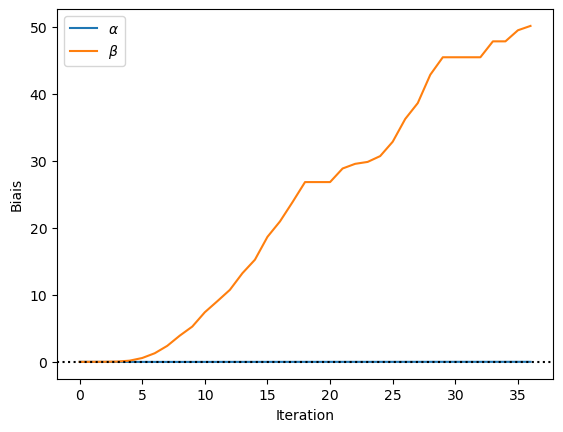

In [262]:
# plt.plot([param["H0"]-x0["H0"] for param in iter_params], label='$H_0$')
plt.plot([param["coef"]-x0["coef"] for param in iter_params], label=['$\\alpha$', '$\\beta$'])
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Biais')
plt.axhline(0, linestyle=':', color='k')
plt.show()

In [ ]:
with open("outdir/salt_uchuu_edris.pkl", "wb") as f:
    pickle.dump(exp, f)
    pickle.dump(obs, f)
    pickle.dump(cov, f)
    pickle.dump(res, f)
    pickle.dump(L, f)
    pickle.dump(iter_params, f)

### Bin number ?

In [ ]:
from tqdm.auto import tqdm

In [ ]:
n_b = [2, 3, 4, 5, 6, 7, 8, 9, 10]
n = len(index)

In [ ]:
z_bins = [
    edris.tools.log_bins(data.loc[index]["z"].min() - 1e-4, 0.06, n_bins)
    for n_bins in n_b
]

In [ ]:
results = []
covs = []

for n_bins in tqdm(n_b):
    exp, cov, obs = sncosmo_to_edris(res_sn, data, index[goods], n_bins=n_bins)
    x0 = {
        "mu_bins": jnp.zeros(len(exp["z_bins"])),
        "coef": jnp.array([-0.14, 3.15]),
        "variables": jnp.array(obs.variables.reshape((2, -1))),
    }
    # Apply a first standardization guess
    delta_mu = obs.mag - edris.models.sn1a_model(x0, exp).mag
    interpol_matrix = edris.tools.linear_interpolation_matrix(
        jnp.log10(exp["z"]), jnp.log10(exp["z_bins"])
    )
    mu_start = jnp.linalg.solve(
        jnp.dot(interpol_matrix.T, interpol_matrix),
        jnp.dot(interpol_matrix.T, delta_mu),
    )
    x0["mu_bins"] = mu_start
    L = lambda x: edris.tools.restrict(
        edris.models.likelihood,
        {
            "sigma_int": 0.1,
        },
    )(
        x,
        exp,
        cov_sel,
        obs,
        cosmo=edris.cosmo.binned_cosmo,
        truncated=False,
        restricted=False,
    )
    res, loss, lmbda, iter_params = edris.minimize.tncg(
        L,
        x0,
        1000,
        lmbda=1e4,
        tol=1e-2,
        verbose=True,
        max_iter_tncg=None,
    )
    hess = jax.hessian(L)(res)
    n_var = len(hess["coef"]["coef"])
    n_bins = len(hess["mu_bins"]["mu_bins"])
    n = hess["variables"]["variables"].shape[1]
    row1 = jnp.hstack(
        (
            hess["coef"]["coef"],
            hess["coef"]["mu_bins"],
            hess["coef"]["variables"].reshape(n_var, n * n_var),
        )
    )
    row2 = jnp.hstack(
        (
            hess["mu_bins"]["coef"],
            hess["mu_bins"]["mu_bins"],
            hess["mu_bins"]["variables"].reshape(n_bins, n * n_var),
        )
    )
    row3 = jnp.hstack(
        (
            hess["variables"]["coef"].reshape(n * n_var, n_var),
            hess["variables"]["mu_bins"].reshape(n * n_var, n_bins),
            hess["variables"]["variables"].reshape(n * n_var, n * n_var),
        )
    )
    flatten_hessian = jnp.vstack((row1, row2, row3))
    cov_res = jnp.linalg.inv(0.5 * flatten_hessian)
    covs.append(cov_res)
    results.append(res)

In [ ]:
n_var = 2
for img, n_bins in zip(covs, n_b):
    fig, ax2 = plt.subplots(figsize=(7, 7))
    sigma_inv = jnp.diag(1 / jnp.sqrt(jnp.diag(img)))
    corr = jnp.matmul(sigma_inv, jnp.matmul(img, sigma_inv))

    im2 = ax2.imshow(
        corr[: n_bins + 2, : n_bins + 2], norm=colors.Normalize(vmin=-1.0, vmax=1.0)
    )
    ax2.set_title("Correlation of coefs and mu_bins")
    ax2.figure.colorbar(im2, ax=ax2)

    plt.show()

In [ ]:
plt.figure("residuals", figsize=(10, 5))
for bins, cov, res in zip(z_bins, covs, results):
    plt.errorbar(
        bins,
        res["mu_bins"] - (jnp.array(cosmo.distmod(np.array(bins))) - 19.3),
        yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + len(bins), 2 : 2 + len(bins)])),
        label=f"{len(bins)}",
    )
plt.title("Residuals")
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{Planck\_18}$")
# plt.savefig(f'../figures/edris_{n}sn_bias.png')
plt.xscale("log")
plt.hlines(0, 1e-4, 0.06, linestyle="dotted", color="k")
plt.legend()

In [ ]:
plt.figure("hubble", figsize=(7, 7))
plt.scatter(exp["z"], obs.mag, s=1, label="Data")
for bins, res in zip(z_bins, results):
    plt.plot(bins, res["mu_bins"], label=f"{len(bins)}")
    plt.xscale("log")
    plt.title("Hubble")
    plt.xlabel("$z$")
    plt.ylabel("$\mu$")
    plt.legend()

In [ ]:
plt.figure("residuals")
for res, bins in zip(results, z_bins):
    plt.scatter(
        exp["z"],
        obs.mag - edris.models.sn1a_model(res, {"z_bins": bins, "z": exp["z"]}).mag,
        s=0.5,
        alpha=1,
    )
plt.title("Residuals")
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{obs}$")
# plt.savefig(f'../figures/edris_{n}sn_bias.png')
plt.xscale("log")

# Fit cosmo

In [ ]:
with open("outdir/SN_Uchuu_edris_res.pkl", "rb") as f:
    exp = pickle.load(f)
    obs = pickle.load(f)
    cov = pickle.load(f)
    res = pickle.load(f)
    cov_res = pickle.load(f)
    iter_params = pickle.load(f)

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)

In [ ]:
std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])
std_mag

In [ ]:
exp

In [ ]:
from scipy.interpolate import interp1d
from astropy.constants import c
from scipy.integrate import quad
from astropy.cosmology import Planck18 as cosmo
from scipy.optimize import curve_fit


def fit_cosmo(z_bins, mu_bins, cov):
    def dist(z, Omega_r, Omega_m, Omega_l, H0):
        Omega_k = 1.0 - Omega_m - Omega_l - Omega_r
        return quad(
            lambda z1: (
                Omega_m * (1 + z1) ** 3
                + Omega_r * (1 + z1) ** 4
                + Omega_k * (1 + z1) ** 2
                + Omega_l
            )
            ** (-0.5)
            * c.value
            * 10 ** (-3)
            / H0,
            0,
            z,
        )

    dist_vec = np.vectorize(dist)

    def z_to_mag(
        z, Omega_m, Omega_r, Omega_l=cosmo.Ode0, Mb=25 - 19.3, H0=cosmo.H0.value
    ):
        return (
            5.0
            * np.log10(abs((z + 1.0) * dist_vec(z, Omega_r, Omega_m, Omega_l, H0)[0]))
            + Mb
        )

    (
        popt,
        pcov,
    ) = curve_fit(
        z_to_mag,
        z_bins,
        mu_bins,
        sigma=cov,
        p0=[cosmo.Om0, cosmo.Ogamma0 + cosmo.Onu0],
        bounds=([0.0, 0.0], [1.0, 1.0]),
    )
    mag_to_z_cosmo = jnp.vectorize(
        interp1d(
            z_to_mag(np.linspace(1e-6, 0.1, 10000), *popt),
            np.linspace(1e-6, 0.1, 10000),
        ),
        signature="(k)->(k)",
    )

    return popt, pcov, mag_to_z_cosmo, z_to_mag

In [ ]:
fit_cosmo(
    exp["z_bins"],
    res["mu_bins"],
    cov_res[n_var : n_bins + n_var, n_var : n_bins + n_var],
)

In [ ]:
n_var = 2

popt, pcov, mag_to_z_cosmo, z_to_mag = fit_cosmo(
    exp["z_bins"],
    res["mu_bins"],
    cov_res[n_var : n_bins + n_var, n_var : n_bins + n_var],
)

data["calc_z_cosmo"] = np.NaN
data.loc[data[data["used_edris"]].index, "calc_z_cosmo"] = mag_to_z_cosmo(std_mag)

# with open(f"outdir/SN_Uchuu_modelcov.pkl", 'wb') as f:
#     pickle.dump(dset.data, f)
#     pickle.dump(data, f)
#     pickle.dump(results, f)
#     pickle.dump(meta, f)

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
)

ax1.errorbar(
    exp["z_bins"],
    res["mu_bins"],
    yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
    color="tab:blue",
    label="edris",
)
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    mag_Planck18(np.linspace(5e-3, 0.06, 1000)),
    color="tab:green",
    linestyle=":",
    label="Planck18",
)
ax1.plot(
    np.linspace(5e-3, 0.06, 1000),
    z_to_mag(np.linspace(5e-3, 0.06, 1000), *popt),
    color="tab:red",
    label="fit",
)

ax1.scatter(
    exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
)
ax1.legend()
ax1.set_ylabel(r"$\mu$")
fig.suptitle(r"Modèle $\Lambda CDM$ fitté")

ax2.errorbar(
    exp["z_bins"],
    res["mu_bins"] - mag_Planck18(exp["z_bins"]),
    yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
    color="tab:blue",
)
ax2.plot(
    np.linspace(5e-3, 0.06, 1000),
    z_to_mag(np.linspace(5e-3, 0.06, 1000), *popt)
    - mag_Planck18(np.linspace(5e-3, 0.06, 1000)),
    color="tab:red",
)
ax2.scatter(exp["z"], std_mag - mag_Planck18(exp["z"]), color="k", s=0.5, alpha=0.3)
lims = ax2.get_xlim()
ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
ax2.set_xlim(*lims)
ax2.set_ylabel(r"$\Delta\mu$")
ax2.set_xlabel(r"$z$")
plt.savefig("../figures/edris_model_fit.png")

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2, sharey="row", figsize=(15, 10)
)
ax1.scatter(
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["z_cosmo"]) * c,
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["calc_z_cosmo"]) * c,
    s=1,
)
ax1.plot(
    np.linspace(-0.01, 0.01, 1000) * c,
    np.linspace(-0.01, 0.01, 1000) * c,
    ":k",
    label="baseline $z_{edris}=z_{uchuu}$",
)
ax1.set_ylabel(r"$pv_{edris}$")
fig.suptitle(r"Is the $z_{cosmo}$ reconstructed by edris the same as the uchuu one ?")

ax2.axis("off")

ax3.scatter(
    data[data["used_edris"]]["z"],
    (data[data["used_edris"]]["calc_z_cosmo"] - data[data["used_edris"]]["z_cosmo"])
    * c,
    s=1,
)
ax3.plot(np.linspace(1e-3, 0.06, 1000), np.zeros(1000), ":k")
ax3.set_xlabel(r"$pv_{uchuu}$")
ax3.set_ylabel(r"$\Delta pv$")

delta_pv = (
    data[data["used_edris"]]["calc_z_cosmo"] - data[data["used_edris"]]["z_cosmo"]
) * c

ax4.hist(delta_pv, bins=60, orientation="horizontal")
m = ax4.get_xlim()[1]
ax4.hlines(
    delta_pv.mean(),
    xmin=0,
    xmax=m,
    color="r",
    label=rf"Mean; $\Delta z = {delta_pv.mean():.2e} km/s",
)
ax4.hlines(
    [delta_pv.mean() - delta_pv.std(), delta_pv.mean() + delta_pv.std()],
    xmin=0,
    xmax=m,
    color="r",
    linestyle=":",
    label=rf"1 sigma; $\sigma = {delta_pv.std():.2e} km/s",
)
ax4.set_xlabel(r"Count")
fig.legend(loc=1, bbox_to_anchor=(0.4, 0.4, 0.5, 0.5))
plt.savefig("../figures/edris_vp_uchuu_vs_edris.png")

In [ ]:
# _=plt.hist(data[data["used_edris"]]["true_z_cosmo"] - data[data["used_edris"]]["calc_z_cosmo"], bins=60, histtype="step")
_ = plt.hist(
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["z_cosmo"]) * c,
    bins=60,
    histtype="step",
    label="PV from Uchuu",
)
_ = plt.hist(
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["calc_z_cosmo"]) * c,
    bins=60,
    histtype="step",
    label="PV reconstructed",
)
plt.xlabel(r"$pv$")
plt.ylabel("Count")
plt.legend()

In [ ]:
plt.scatter(
    data[data["used_edris"]]["z"],
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["calc_z_cosmo"]) * c,
    s=1,
    label="Edris",
)
plt.scatter(
    data[data["used_edris"]]["z"],
    (data[data["used_edris"]]["z"] - data[data["used_edris"]]["z_cosmo"]) * c,
    s=1,
    label="Uchuu",
)
plt.ylabel(r"$pv$")
plt.xlabel(r"$z$")
plt.title(r"Peculiar velocities relative to redshift")
plt.legend()

In [ ]:
with open("outdir/SN_Uchuu_modelcov.pkl", "wb") as f:
    pickle.dump(lc, f)
    pickle.dump(data, f)
    pickle.dump(res_sn, f)
    pickle.dump(meta, f)

In [ ]:
_ = corner_(
    data[data["used_edris"]],
    var_names=[
        "x0",
        "x1",
        "c",
        "tmax",
        "ra",
        "dec",
        "z",
        "calc_z_cosmo",
        "true_z_cosmo",
    ],
)

### Likelihood profiling

In [ ]:
profile = lambda x, y: edris.models.likelihood(
    {
        "mu_bins": jnp.array(cosmo.distmod(np.array(exp["z_bins"]))) - 19.3,
        "coef": jnp.array([x, y]),
        "variables": jnp.array(obs.variables.reshape((2, -1))),
        "sigma_int": 0.1,
    },
    exp,
    cov_sel,
    obs,
    cosmo=edris.cosmo.binned_cosmo,
    truncated=False,
    restricted=False,
)
profile = jnp.vectorize(profile)
profile = jax.jit(profile)

In [ ]:
xx, yy = np.meshgrid(np.linspace(-0.2, -0.08, 1000), np.linspace(3.0, 3.5, 1000))

In [ ]:
profile_L = profile(xx, yy)

In [ ]:
profile_L.min()

In [ ]:
plt.imshow(profile_L, extent=[-0.2, -0.08, 3.5, 3], aspect="auto")
plt.colorbar()

In [ ]:
plt.figure()
_ = plt.plot(yy[:, 450:550], profile_L[:, 450:550])

In [ ]:
plt.figure()
_ = plt.plot(xx[200:400, :].T, profile_L[200:400, :].T)

In [ ]:
plt.figure()
plt.imshow(profile_L[200:400, 450:550], cmap="viridis")
plt.colorbar()

In [ ]:
profile = lambda x, y: edris.models.likelihood(
    {
        "mu_bins": jnp.array(cosmo.distmod(np.array(exp["z_bins"]))) - 19.3,
        "coef": jnp.array([x, y]),
        "variables": jnp.array(obs.variables.reshape((2, -1))),
        "sigma_int": 0.1,
    },
    exp,
    cov_sel,
    obs,
    cosmo=edris.cosmo.binned_cosmo,
    truncated=False,
    restricted=False,
)
profile = jnp.vectorize(profile)
profile = jax.jit(profile)

In [ ]:
xx, yy = np.meshgrid(np.linspace(-0.2, -0.08, 1000), np.linspace(3.0, 3.5, 1000))

In [ ]:
profile_L = profile(xx, yy)

In [ ]:
profile_L.min()

In [ ]:
plt.imshow(profile_L, extent=[-0.2, -0.08, 3.5, 3], aspect="auto")
plt.colorbar()

In [ ]:
plt.figure()
_ = plt.plot(yy[:, 450:550], profile_L[:, 450:550])

In [ ]:
plt.figure()
_ = plt.plot(xx[200:400, :].T, profile_L[200:400, :].T)

In [ ]:
plt.figure()
plt.imshow(profile_L[200:400, 450:550], cmap="viridis")
plt.colorbar()

# MOCKSURVEY

In [ ]:
from mocksurvey.simulations import *

In [ ]:
from skysurvey import DataSet

with open("outdir/SN_Uchuu_modelcov.pkl", "rb") as f:
    lc = pickle.load(f)
    data = pickle.load(f)

data = data.drop(columns=['converged', 'used_edris', 'calc_z_cosmo', 'redshift'])

dset = DataSet(lc)
dset.set_survey(extract_ztf())
snia = SNeIa_full_bgs.from_data(data)
dset.set_targets(snia)
dset.data.index = [item[0] for item in dset.data.index.to_flat_index()]
dset.data.index = dset.data.index.set_names('index')

In [ ]:
detected = dset.targets.data[dset.targets.data["good"]].index

In [ ]:
output = dset.data.loc[detected].join(dset.targets.data.loc[detected])

In [ ]:
def eliminate_points_not_in_model(output, targets):
    logging.info('Eliminating points not in model')
    def checkwave(b, minwave, maxwave):
        band = sncosmo.get_bandpass(b)
        return band.minwave() >= minwave and band.maxwave() <= maxwave
    sncosmo_model = targets.template.sncosmo_model
    passcheck = np.zeros(len(output))
    unique_idx = np.unique(output['snid'].values)
    for index in unique_idx:
        mask = output['snid'] == index
        suboutput = output.loc[mask]
        bands_unique, band_index = build_band_index(suboutput.band.values)
        sncosmo_model.set(z = suboutput.z.values[0],
                          t0 = suboutput.t0.values[0],
                          x0 = suboutput.x0.values[0],
                          x1 = suboutput.x1.values[0],
                          c = suboutput.c.values[0],
                          mwebv = suboutput.mwebv.values[0])
        minwave = sncosmo_model.minwave()
        maxwave = sncosmo_model.maxwave()
        passcheck_unique = np.array([checkwave(band, minwave, maxwave) for band in bands_unique])
        passcheck[mask] = passcheck_unique[band_index]
    output['passcheck'] = pd.Series(passcheck, index=output.index)
    return output.loc[output.passcheck.values == 1]

def get_trueflux_and_amplitude(output, targets):
    logging.info('Getting true fluxes and amplitudes')
    sncosmo_model = targets.template.sncosmo_model
    fluxtrue = np.zeros(len(output))
    amplitudes = np.zeros(len(output))
    unique_idx = np.unique(output['snid'].values)
    for index in unique_idx:
        mask = output['snid'] == index
        output_to_fit = output.loc[mask]
        band_to_fit = output_to_fit['band'].to_list()
        time_to_fit = output_to_fit['time'].to_list()
        zp_to_fit = output_to_fit['zp'].to_list()
        zpsys_to_fit = output_to_fit['zpsys'].to_list()
        time_at_max = output_to_fit['t0'].to_list()
        sncosmo_model.set(z = output_to_fit.z.values[0],
                          t0 = output_to_fit.t0.values[0],
                          x0 = output_to_fit.x0.values[0],
                          x1 = output_to_fit.x1.values[0],
                          c = output_to_fit.c.values[0],
                          mwebv = output_to_fit.mwebv.values[0])
        fluxtrue[mask] = sncosmo_model.bandflux(band_to_fit,
                                                time_to_fit,
                                                zp_to_fit,
                                                zpsys_to_fit)
        amplitudes[mask] = sncosmo_model.bandflux(band_to_fit,
                                                  time_at_max,
                                                  [30 for i in range(len(output_to_fit))],
                                                  zpsys_to_fit)
    output['fluxtrue'] = pd.Series(fluxtrue, index=output.index)
    output['trueA'] = pd.Series(amplitudes, index=output.index)
    return output

In [ ]:
output['snid'] = output.index

In [ ]:
# output = get_detected_sn(dset, detlimit=7, detnumber= 10, per_band=False)
output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)
output = eliminate_points_not_in_model(output, snia)
output = get_trueflux_and_amplitude(output, snia)
output = get_snr(output)

In [ ]:
output = discard_small_snr(output, threshold=0)
output = discard_skysurvey_flux(output)

In [ ]:
output['snid'] = output.index

In [ ]:
output["survey"] = "ztf"

In [ ]:
output.to_csv("outdir/SN_Uchuu_tmp.csv", encoding="utf-8", index=False)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def f(x, a, b, c):
    """ """
    return a * x**2 + b * x + c


def generate_mock_sample(mock_ztf_path):
    """
    Generates the mock sample based on the generated mock survey.

    !! Need to generate the mock sample first

    Parameters:
    ------------
    mock_ztf_path : str
        Path to the generated ztf mock sample

    Returns:
    ------------
    : pandas.DataFrame
        Mock spectra

    """
    d_time = np.array([])
    d_wavelength = np.array([])
    d_flux = np.array([])
    d_fluxerr = np.array([])
    d_valid = np.array([])
    d_spec = np.array([])
    d_exptime = np.array([])
    d_snid = np.array([])
    d_flux_true = np.array([])
    d_x0 = np.array([])
    d_x1 = np.array([])
    d_c = np.array([])
    d_t0 = np.array([])
    d_mwebv = np.array([])
    d_z = np.array([])

    mock_survey = pd.read_csv(mock_ztf_path)
    idx = mock_survey["fluxtrue"] != 0
    mock_survey = mock_survey[idx]

    mock_x0 = mock_survey["x0"]
    mock_x1 = mock_survey["x1"]
    mock_c = mock_survey["c"]
    mock_t0 = mock_survey["t0"]
    mock_z = mock_survey["z"]
    mock_mwebv = mock_survey["mwebv"]
    mock_snid = np.unique(mock_survey["snid"])

    n = len(mock_snid)
    length_wave = np.array([218, 437, 3258, 656, 868])
    popt = np.array([-7.87649259e-07, 1.08382223e-02, -2.44390307e01])
    a, b, c = popt
    for i in tqdm(range(n)):
        x0 = np.array(mock_x0[mock_survey["snid"] == mock_snid[i]])[0]
        x1 = np.array(mock_x1[mock_survey["snid"] == mock_snid[i]])[0]
        c = np.array(mock_c[mock_survey["snid"] == mock_snid[i]])[0]
        t0 = np.array(mock_t0[mock_survey["snid"] == mock_snid[i]])[0]
        z = np.array(mock_z[mock_survey["snid"] == mock_snid[i]])[0]
        mwebv = np.array(mock_mwebv[mock_survey["snid"] == mock_snid[i]])[0]

        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900.0, 3400.0)
        max_wave = np.random.uniform(9000.0, 11000.0)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        mjd = np.random.choice(mock_survey["time"][(mock_survey["snid"] == mock_snid[i]) & (mock_survey["time"].between(t0 - 20, t0 + 50))])

        source = source=sncosmo.SALT2Source(modeldir='./data/SALT_snf', m0file='nacl_m0_test.dat', m1file='nacl_m1_test.dat', clfile='nacl_color_law_test.dat')
        model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])
        p = {"z": z, "t0": t0, "x0": x0, "x1": x1, "c": c, "mwebv": mwebv, "mwr_v": 3.1}
        model.set(**p)

        min_w = model.minwave()
        max_w = model.maxwave()

        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                flux_true = model.flux(mjd, wavelength[wavelength < max_w])
                wavelength = wavelength[wavelength < max_w]
            except:
                flux_true = model.flux(mjd, wavelength[wavelength > min_w])
                wavelength = wavelength[wavelength > min_w]
        # j = np.random.randint(0, N)
        # err_ = spec_data['fluxerr'][j]
        # flx_ = spec_data['flux'][j]
        # norm = flx_/np.max(flux_true)

        # if norm == norm and norm != np.inf and norm != -np.inf:
        #    flux_true *= norm
        # flux_err = err_*np.random.randn(len(flux_true))
        norm_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1e12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true / f(wavelength, a, b, c)) * np.random.randn(
            len(flux_true)
        )
        flux = flux_true + 0.5 * flux_err

        d_time = np.append(d_time, np.repeat(mjd, len(flux)))
        d_wavelength = np.append(d_wavelength, wavelength)
        d_flux = np.append(d_flux, flux)
        d_fluxerr = np.append(d_fluxerr, np.abs(flux_err))
        d_flux_true = np.append(d_flux_true, flux_true)
        d_valid = np.append(d_valid, np.repeat(1, len(flux)))
        d_exptime = np.append(d_exptime, np.repeat(np.nan, len(flux)))
        d_snid = np.append(d_snid, np.repeat(mock_snid[i], len(flux)))
        d_spec = np.append(d_spec, np.repeat(i, len(flux)))
        d_x0 = np.append(d_x0, np.repeat(x0, len(flux)))
        d_x1 = np.append(d_x1, np.repeat(x1, len(flux)))
        d_c = np.append(d_c, np.repeat(c, len(flux)))
        d_t0 = np.append(d_t0, np.repeat(t0, len(flux)))
        d_z = np.append(d_z, np.repeat(z, len(flux)))
        d_mwebv = np.append(d_mwebv, np.repeat(mwebv, len(flux)))
    data_sim = pd.DataFrame(
        {
            "spec": d_spec,
            "time": d_time,
            "wavelength": d_wavelength,
            "flux": d_flux,
            "fluxerr": d_fluxerr,
            "valid": d_valid,
            "spec": d_spec,
            "exptime": d_exptime,
            "snid": d_snid,
            "flux_true": d_flux_true,
            "x0": d_x0,
            "x1": d_x1,
            "c": d_c,
            "t0": d_t0,
            "mwebv": d_mwebv,
            "z": d_z,
        }
    )
    return data_sim

In [ ]:
data_mock = generate_mock_sample("outdir/SN_Uchuu_tmp.csv")
data_mock.to_csv("outdir/SN_Uchuu_spectra.csv")

In [ ]:
data_mock = pandas.read_csv("outdir/SN_Uchuu_spectra.csv", index_col=0)

In [ ]:
plt.close()

In [ ]:
%matplotlib inline

for i in tqdm(data_mock.groupby("spec")["spec"].mean().loc[:30]):
    plt.errorbar(data_mock[data_mock['spec']==i]["wavelength"], data_mock[data_mock['spec']==i]["flux"], data_mock[data_mock['spec']==i]["fluxerr"], capsize=2)
    
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.yscale("log")